# Time Series Analysis: Household Energy Consumption
## Part 1: Data Loading & Initial Forecasting (Before Cleaning)

**Dataset:** UCI Individual Household Electric Power Consumption

**Authors:** [Muhammad Umar Ibrahim, Ritik Dhingana]

---

## 1. Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Stationarity tests
from statsmodels.tsa.stattools import adfuller, kpss

# ACF/PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL

plt.style.use('seaborn-v0_8-whitegrid')


## 2. Load Data

**Dataset Info:**
- Source: UCI Machine Learning Repository
- Period: December 2006 to November 2010 (47 months)
- Sampling: 1-minute intervals
- Total: ~2 million measurements
- Location: Household in Sceaux, France

**Download:** https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

In [ ]:
try:
    from ucimlrepo import fetch_ucirepo
    
    # Fetch dataset
    dataset = fetch_ucirepo(id=235)
    
    # Get data
    df = dataset.data.features
    print("Data loaded from UCI repository!")
    print(f"Shape: {df.shape}")
    
except:
    print("ucimlrepo not available.")

Data loaded from UCI repository!
Shape: (2075259, 9)


In [ ]:
# data structure
print("Data Info:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
df.head()

Data Info:
Shape: (2075259, 9)

Columns: ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

First 5 rows:


Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0

# Data preprocessing

In [ ]:
# if data has Date and Time columns separately, combine them

if 'Date' in df.columns and 'Time' in df.columns:
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
    df.set_index('datetime', inplace=True)
    df.drop(['Date', 'Time'], axis=1, inplace=True)

# Convert to numeric
if 'Global_active_power' in df.columns:
    df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

print(f"Index type: {type(df.index)}")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Date range: 2006-12-16 17:24:00 to 2010-11-26 21:02:00


In [6]:
if len(df) > 10000:
    # Resample to HOURLY data
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_daily = df[numeric_cols].resample('D').mean()
    print(f"Resampled from {len(df)} to {len(df_daily)} hourly records")
else:
    df_daily = df.copy()

df_daily.head()

Resampled from 2075259 to 1442 hourly records


Global_active_power  Sub_metering_3
datetime                                       
2006-12-16             3.053475       12.439394
2006-12-17             2.354486        9.264583
2006-12-18             1.530435        9.734722
2006-12-19             1.157079        4.303472
2006-12-20             1.545658        9.765972

# Our target: Global Active Power (in kilowatts)

In [ ]:
# it is represented by the total active power consumed by the household

ts = df_daily['Global_active_power'].copy()

# missing values
missing_count = ts.isnull().sum()
print(f"Missing values: {missing_count} ({missing_count/len(ts)*100:.2f}%)")

if missing_count > 0:
    ts = ts.interpolate(method='linear')
    ts = ts.ffill().bfill()
    print(f"Missing values after interpolation: {ts.isnull().sum()}")

print(f"\nGlobal Active Power Statistics:")
print(f"  Mean: {ts.mean():.3f} kW")
print(f"  Std:  {ts.std():.3f} kW")
print(f"  Min:  {ts.min():.3f} kW")
print(f"  Max:  {ts.max():.3f} kW")

Missing values: 9 (0.62%)
Missing values after interpolation: 0

Global Active Power Statistics:
  Mean: 1.091 kW
  Std:  0.420 kW
  Min:  0.174 kW
  Max:  3.315 kW


In [ ]:
# Removing 2006 data (incomplete year)
ts = ts[ts.index.year >= 2007]

print(f"Data after removing 2006:")
print(f"   Date range: {ts.index.min().date()} to {ts.index.max().date()}")
print(f"   Total records: {len(ts)}")
print(f"   Years: {ts.index.year.unique().tolist()}")

Data after removing 2006:
   Date range: 2007-01-01 to 2010-11-26
   Total records: 1426
   Years: [2007, 2008, 2009, 2010]


In [ ]:
# missing data and gaps
print("=" * 50)
print("DATA QUALITY CHECK")
print("=" * 50)

# NaN values
print(f"\nMissing values (NaN): {ts.isna().sum()}")

# date gaps
date_diff = ts.index.to_series().diff()
large_gaps = date_diff[date_diff > pd.Timedelta(days=1)]
print(f"\nDate gaps larger than 1 day:")
print(large_gaps)

# Visualize the problematic period
print(f"\nData around 2008-07:")
print(ts['2008-06-15':'2008-09-15'])

DATA QUALITY CHECK

Missing values (NaN): 0

Date gaps larger than 1 day:
Series([], Freq: D, Name: datetime, dtype: timedelta64[ns])

Data around 2008-07:
datetime
2008-06-15    1.589654
2008-06-16    0.904892
2008-06-17    0.795197
2008-06-18    1.315006
2008-06-19    1.102835
                ...   
2008-09-11    0.714385
2008-09-12    0.967196
2008-09-13    1.132942
2008-09-14    1.094671
2008-09-15    1.178964
Freq: D, Name: Global_active_power, Length: 93, dtype: float64


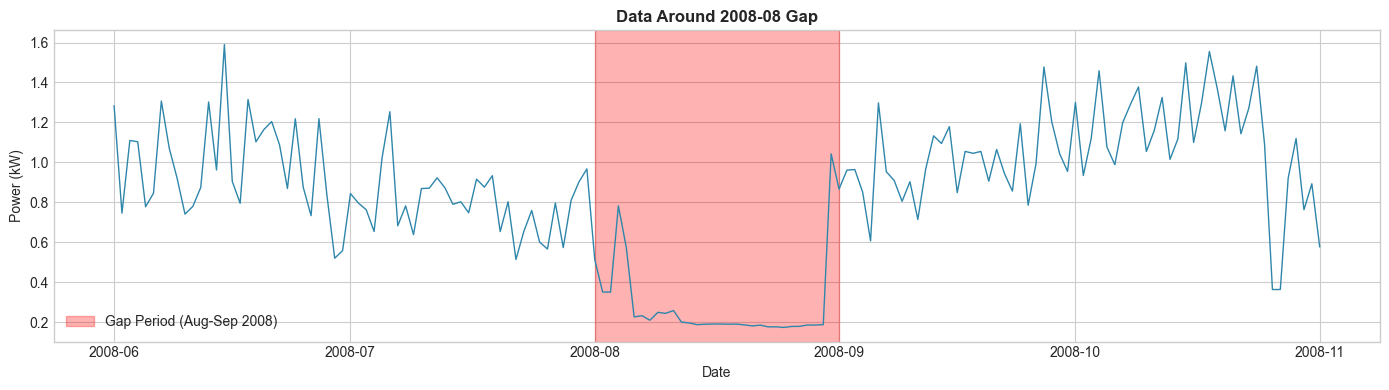

In [ ]:
# the gap period
plt.figure(figsize=(14, 4))
plt.plot(ts['2008-06-01':'2008-11-01'].index, ts['2008-06-01':'2008-11-01'].values, 
         color='#2E86AB', linewidth=1)
plt.title('Data Around 2008-08 Gap', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.axvspan(pd.Timestamp('2008-08-01'), pd.Timestamp('2008-09-01'), 
            alpha=0.3, color='red', label='Gap Period (Aug-Sep 2008)')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Data Visualization

Plot the complete time series with rolling averages

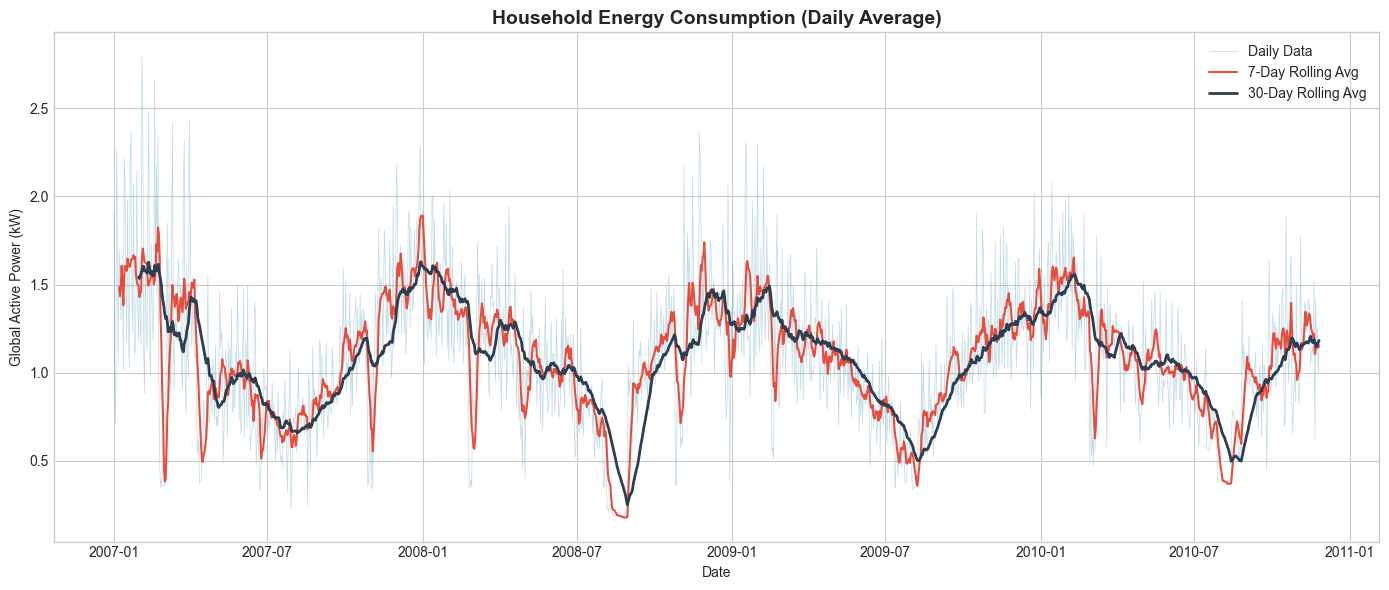

In [ ]:
plt.figure(figsize=(14, 6))

# Original data (faded)
plt.plot(ts.index, ts.values, color='#2E86AB', alpha=0.3, linewidth=0.5, label='Daily Data')

# 7-day rolling average (smooth line)
rolling_7 = ts.rolling(window=7).mean()
plt.plot(rolling_7.index, rolling_7.values, color='#E74C3C', linewidth=1.5, label='7-Day Rolling Avg')

# 30-day rolling average (trend)
rolling_30 = ts.rolling(window=30).mean()
plt.plot(rolling_30.index, rolling_30.values, color='#2C3E50', linewidth=2, label='30-Day Rolling Avg')

plt.title('Household Energy Consumption (Daily Average)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

Analyze patterns by month and day of week (Daily Data)

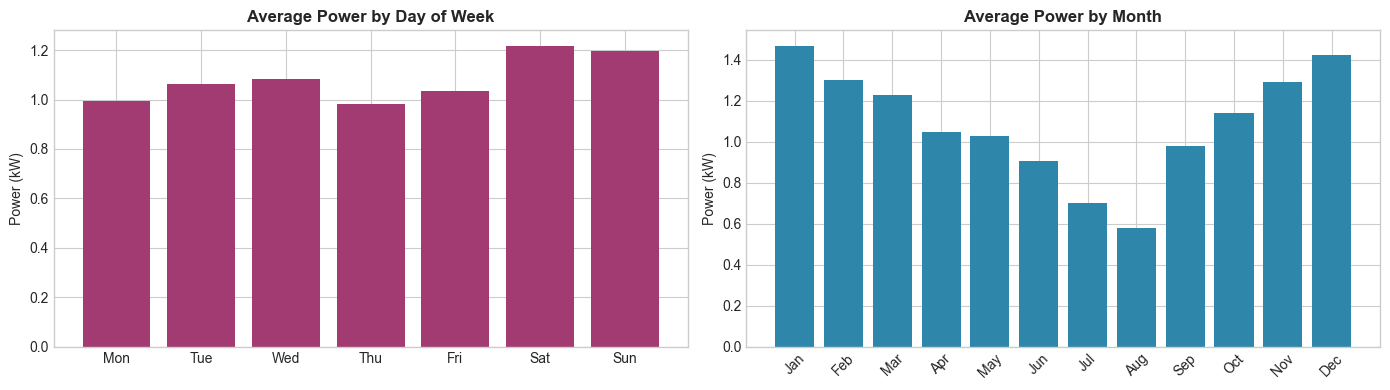


📌 Key Observations:
   - Highest consumption month: Jan (1.468 kW)
   - Lowest consumption month: Aug (0.580 kW)
   - Weekend vs Weekday difference visible


In [ ]:
df_analysis = pd.DataFrame({'power': ts})
df_analysis['month'] = df_analysis.index.month
df_analysis['dayofweek'] = df_analysis.index.dayofweek
df_analysis['year'] = df_analysis.index.year

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Day of week average
daily = df_analysis.groupby('dayofweek')['power'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0].bar(days, daily.values, color='#A23B72')
axes[0].set_title('Average Power by Day of Week', fontweight='bold')
axes[0].set_ylabel('Power (kW)')

# Monthly average
monthly = df_analysis.groupby('month')['power'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1].bar(months, monthly.values, color='#2E86AB')
axes[1].set_title('Average Power by Month', fontweight='bold')
axes[1].set_ylabel('Power (kW)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print(f"   - Highest consumption month: {months[monthly.idxmax()-1]} ({monthly.max():.3f} kW)")
print(f"   - Lowest consumption month: {months[monthly.idxmin()-1]} ({monthly.min():.3f} kW)")
print(f"   - Weekend vs Weekday difference visible")

## 4. Train-Test Split

In [13]:
# 80-20 split
train_size = int(len(ts) * 0.8)
train = ts[:train_size]
test = ts[train_size:]

print(f"Training: {len(train)} days ({train.index.min().date()} to {train.index.max().date()})")
print(f"Testing:  {len(test)} days ({test.index.min().date()} to {test.index.max().date()})")

Training: 1140 days (2007-01-01 to 2010-02-13)
Testing:  286 days (2010-02-14 to 2010-11-26)


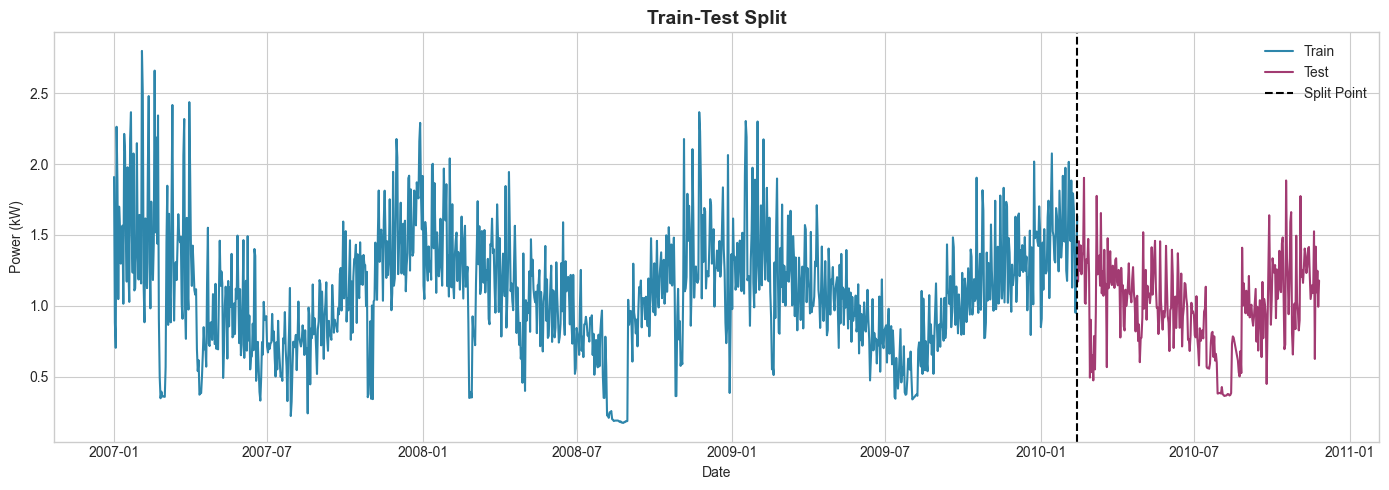

In [14]:
# Visualize split
plt.figure(figsize=(14, 5))
plt.plot(train.index, train.values, label='Train', color='#2E86AB')
plt.plot(test.index, test.values, label='Test', color='#A23B72')
plt.axvline(x=train.index[-1], color='black', linestyle='--', label='Split Point')
plt.title('Train-Test Split', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Evaluation Function

In [15]:
def evaluate_forecast(actual, predicted, model_name):
    """Calculate forecast evaluation metrics"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"\n{model_name}:")
    print(f"  MAE:  {mae:.4f} kW")
    print(f"  RMSE: {rmse:.4f} kW")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

---
# INITIAL FORECASTING (Before any cleaning/analysis)
---

## 6. ARIMA Forecast (Initial)

In [16]:
# Fit ARIMA(2,1,2) - baseline model
print("Fitting ARIMA(2,1,2)...")
arima_model = ARIMA(train, order=(2, 1, 2))
arima_fit = arima_model.fit()

print(f"AIC: {arima_fit.aic:.2f}")
print(f"BIC: {arima_fit.bic:.2f}")

Fitting ARIMA(2,1,2)...
AIC: 570.34
BIC: 595.53


In [17]:
# Forecast
arima_forecast = arima_fit.forecast(steps=len(test))
arima_forecast.index = test.index

# Evaluate
arima_metrics_initial = evaluate_forecast(test.values, arima_forecast.values, 'ARIMA (Initial)')


ARIMA (Initial):
  MAE:  0.4823 kW
  RMSE: 0.5581 kW
  MAPE: 67.40%


## 7. SARIMA Forecast (Initial)

SARIMA adds **seasonal components** - important for energy data which has:
- Weekly patterns (s=7)
- Or yearly patterns (s=365, but computationally expensive)

In [350]:
# Fit SARIMA with weekly seasonality (s=7)
print("Fitting SARIMA(2,1,2)(1,1,1,7)...")
print("(This may take a minute...)")

try:
    sarima_model = SARIMAX(train, 
                          order=(2, 1, 2), 
                          seasonal_order=(1, 1, 1, 7),  # Weekly seasonality
                          enforce_stationarity=False,
                          enforce_invertibility=False)
    sarima_fit = sarima_model.fit(disp=False)
    
    sarima_forecast = sarima_fit.forecast(steps=len(test))
    sarima_forecast.index = test.index
    
    sarima_metrics_initial = evaluate_forecast(test.values, sarima_forecast.values, 'SARIMA (Initial)')
    print(f"AIC: {sarima_fit.aic:.2f}, BIC: {sarima_fit.bic:.2f}")
    sarima_success = True
    
except Exception as e:
    print(f"SARIMA failed: {e}")
    print("Using ARIMA results as fallback...")
    sarima_forecast = arima_forecast.copy()
    sarima_metrics_initial = arima_metrics_initial.copy()
    sarima_success = False

Fitting SARIMA(2,1,2)(1,1,1,7)...
(This may take a minute...)

SARIMA (Initial):
  MAE:  0.8867 kW
  RMSE: 0.9683 kW
  MAPE: 115.08%
AIC: 369.94, BIC: 405.10


c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 8. Prophet Forecast (Initial)

In [ ]:
# Preparing data for Prophet (requires 'ds' and 'y' columns)
prophet_train = pd.DataFrame({
    'ds': train.index,
    'y': train.values
})

print("Fitting Prophet...")
prophet_model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,   # Weekly patterns
    yearly_seasonality=True,   # Yearly patterns (winter/summer)
    changepoint_prior_scale=0.05
)
prophet_model.fit(prophet_train)
print("Prophet model fitted!")

Fitting Prophet...


06:42:57 - cmdstanpy - INFO - Chain [1] start processing
06:42:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted!


In [ ]:
# future dataframe using actual dates
future = pd.DataFrame({'ds': ts.index})
prophet_forecast_full = prophet_model.predict(future)

# Get test predictions
prophet_pred = prophet_forecast_full[prophet_forecast_full['ds'].isin(test.index)]['yhat'].values

# Verify lengths match
print(f"Test length: {len(test)}, Prophet predictions: {len(prophet_pred)}")

# Evaluate
prophet_metrics_initial = evaluate_forecast(test.values, prophet_pred, 'Prophet (Initial)')

Test length: 286, Prophet predictions: 286

Prophet (Initial):
  MAE:  0.1895 kW
  RMSE: 0.2548 kW
  MAPE: 21.35%


## 9. Compare Initial Forecasts

In [ ]:
# Summary table
initial_results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet'],
    'MAE (kW)': [arima_metrics_initial['MAE'], sarima_metrics_initial['MAE'], prophet_metrics_initial['MAE']],
    'RMSE (kW)': [arima_metrics_initial['RMSE'], sarima_metrics_initial['RMSE'], prophet_metrics_initial['RMSE']],
    'MAPE (%)': [arima_metrics_initial['MAPE'], sarima_metrics_initial['MAPE'], prophet_metrics_initial['MAPE']]
})

print("\n" + "="*60)
print("     INITIAL FORECASTING RESULTS (Before Cleaning)")
print("="*60)
display(initial_results.round(4))

# Find best model
best_idx = initial_results['RMSE (kW)'].idxmin()
print(f"\n Best Initial Model: {initial_results.loc[best_idx, 'Model']} (RMSE: {initial_results.loc[best_idx, 'RMSE (kW)']:.4f} kW)")


     INITIAL FORECASTING RESULTS (Before Cleaning)


Model  MAE (kW)  RMSE (kW)  MAPE (%)
0    ARIMA    0.4823     0.5581   67.4022
1   SARIMA    0.3104     0.4197   33.2044
2  Prophet    0.1895     0.2548   21.3550


🏆 Best Initial Model: Prophet (RMSE: 0.2548 kW)


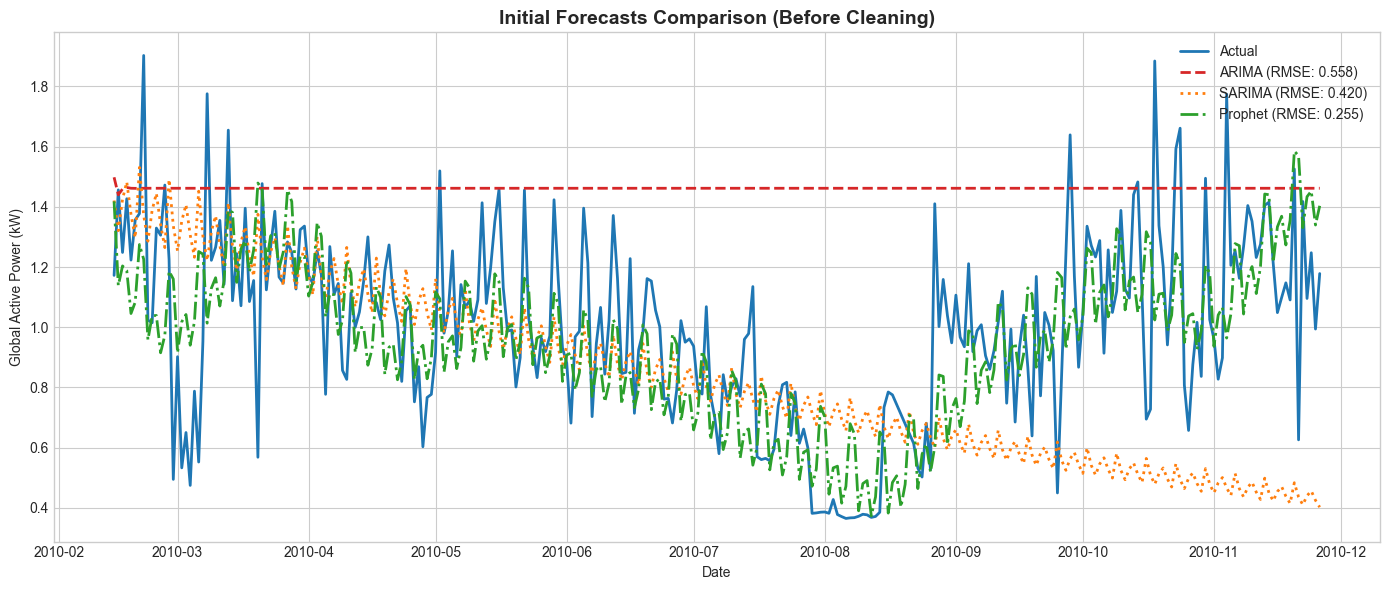

In [ ]:
# Visualize all initial forecasts
plt.figure(figsize=(14, 6))

# Actual
plt.plot(test.index, test.values, color='#1f77b4', linewidth=2, label=f'Actual')

# ARIMA
plt.plot(test.index, arima_forecast.values, color='#d62728', linewidth=2, linestyle='--', 
         label=f'ARIMA (RMSE: {arima_metrics_initial["RMSE"]:.3f})')

# SARIMA
plt.plot(test.index, sarima_forecast.values, color='#ff7f0e', linewidth=2, linestyle=':', 
         label=f'SARIMA (RMSE: {sarima_metrics_initial["RMSE"]:.3f})')

# Prophet
plt.plot(test.index, prophet_pred, color='#2ca02c', linewidth=2, linestyle='-.', 
         label=f'Prophet (RMSE: {prophet_metrics_initial["RMSE"]:.3f})')

plt.title('Initial Forecasts Comparison (Before Cleaning)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

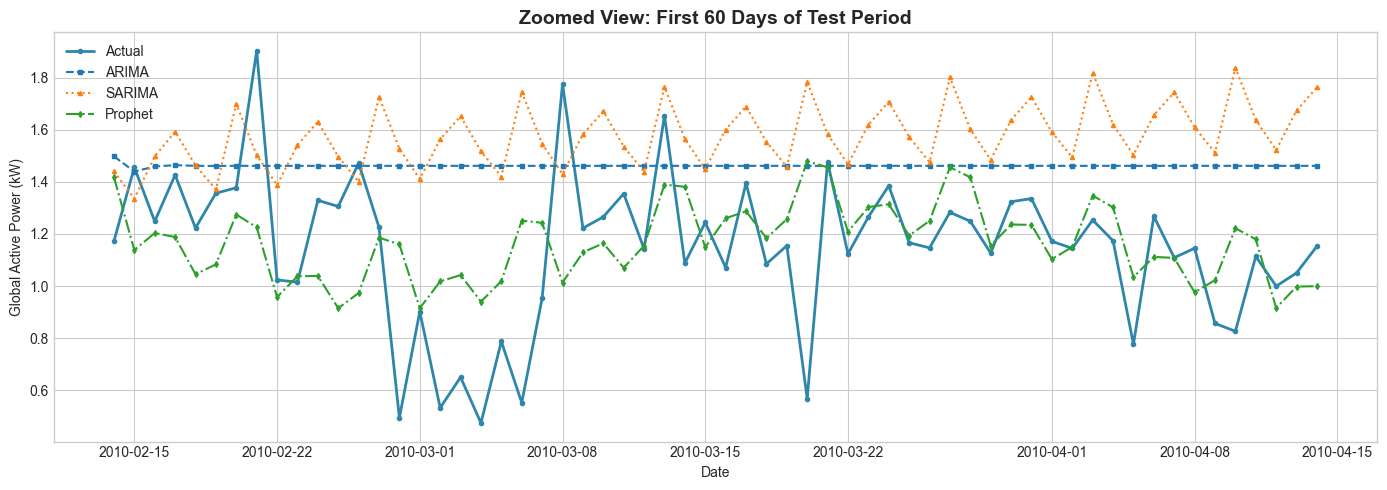

In [ ]:
# Zoomed view - first 30 days of predicted period
zoom_days = 60

plt.figure(figsize=(14, 5))
plt.plot(test.index[:zoom_days], test.values[:zoom_days], 
         label='Actual', color='#2E86AB', linewidth=2, marker='o', markersize=3)
plt.plot(test.index[:zoom_days], arima_forecast.values[:zoom_days], 
         label='ARIMA', linestyle='--', marker='s', markersize=3)
plt.plot(test.index[:zoom_days], sarima_forecast.values[:zoom_days], 
         label='SARIMA', linestyle=':', marker='^', markersize=3)
plt.plot(test.index[:zoom_days], prophet_pred[:zoom_days], 
         label='Prophet', linestyle='-.', marker='d', markersize=3)

plt.title(f'Zoomed View: First {zoom_days} Days of Test Period', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

---
## Summary: Initial Forecasting Results

### What we did:
1. Loaded UCI Household Power Consumption data
2. Resampled to daily frequency
3. Split into train (80%) and test (20%)
4. Applied ARIMA, SARIMA, and Prophet **without proper analysis**

### Key Observations:
- Initial forecasts may not capture all patterns
- We haven't checked stationarity yet
- We haven't detected/removed anomalies yet
- Seasonal patterns may not be optimally modeled

---

## Next Steps (Part 2 & 3):
1. **Stationarity Testing** (ADF test)
2. **ACF/PACF Analysis** (find optimal p, d, q)
3. **Decomposition** (understand trend, seasonality, residuals)
4. **Anomaly Detection** (Z-score, Isolation Forest)
5. **Re-Forecasting** after cleaning
6. **Compare** Before vs After

---

---
# STEP 1: STATIONARITY TESTING
---

## What is Stationarity?

A **stationary** time series has:
- Constant mean over time
- Constant variance over time
- No trend or seasonality

**Why it matters:** ARIMA requires stationary data to work properly!

## 1. ADF Test (Augmented Dickey-Fuller)

In [ ]:
def adf_test(series, title=''):
    """
    Augmented Dickey-Fuller Test
    
    H0 (Null): Series is NON-stationary (has unit root)
    H1 (Alt): Series IS stationary
    
    If p-value < 0.05: Reject H0 → Series is STATIONARY
    If p-value >= 0.05: Fail to reject H0 → Series is NON-STATIONARY
    """
    print(f"\n{'='*50}")
    print(f"ADF Test: {title}")
    print(f"{'='*50}")
    
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Lags Used: {result[2]}")
    print(f"\nCritical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    
    if result[1] < 0.05:
        print(f"\nRESULT: Series is STATIONARY (p-value < 0.05)")
        return True
    else:
        print(f"\nRESULT: Series is NON-STATIONARY (p-value >= 0.05)")
        return False

In [25]:
# Test ORIGINAL series
print("\n" + "#"*50)
print("TESTING ORIGINAL SERIES")
print("#"*50)

is_stationary_original = adf_test(ts, 'Original Energy Consumption')


##################################################
TESTING ORIGINAL SERIES
##################################################

ADF Test: Original Energy Consumption
ADF Statistic: -3.7429
p-value: 0.0035
Lags Used: 22

Critical Values:
   1%: -3.4350
   5%: -2.8636
   10%: -2.5679

✅ RESULT: Series is STATIONARY (p-value < 0.05)


In [ ]:
# FIRST DIFFERENCING to make it stationary
ts_diff = ts.diff().dropna()

print("\n" + "#"*50)
print("TESTING FIRST DIFFERENCE (d=1)")
print("#"*50)

is_stationary_diff = adf_test(ts_diff, 'First Difference')


##################################################
TESTING FIRST DIFFERENCE (d=1)
##################################################

ADF Test: First Difference
ADF Statistic: -10.9295
p-value: 0.0000
Lags Used: 21

Critical Values:
   1%: -3.4350
   5%: -2.8636
   10%: -2.5679

✅ RESULT: Series is STATIONARY (p-value < 0.05)


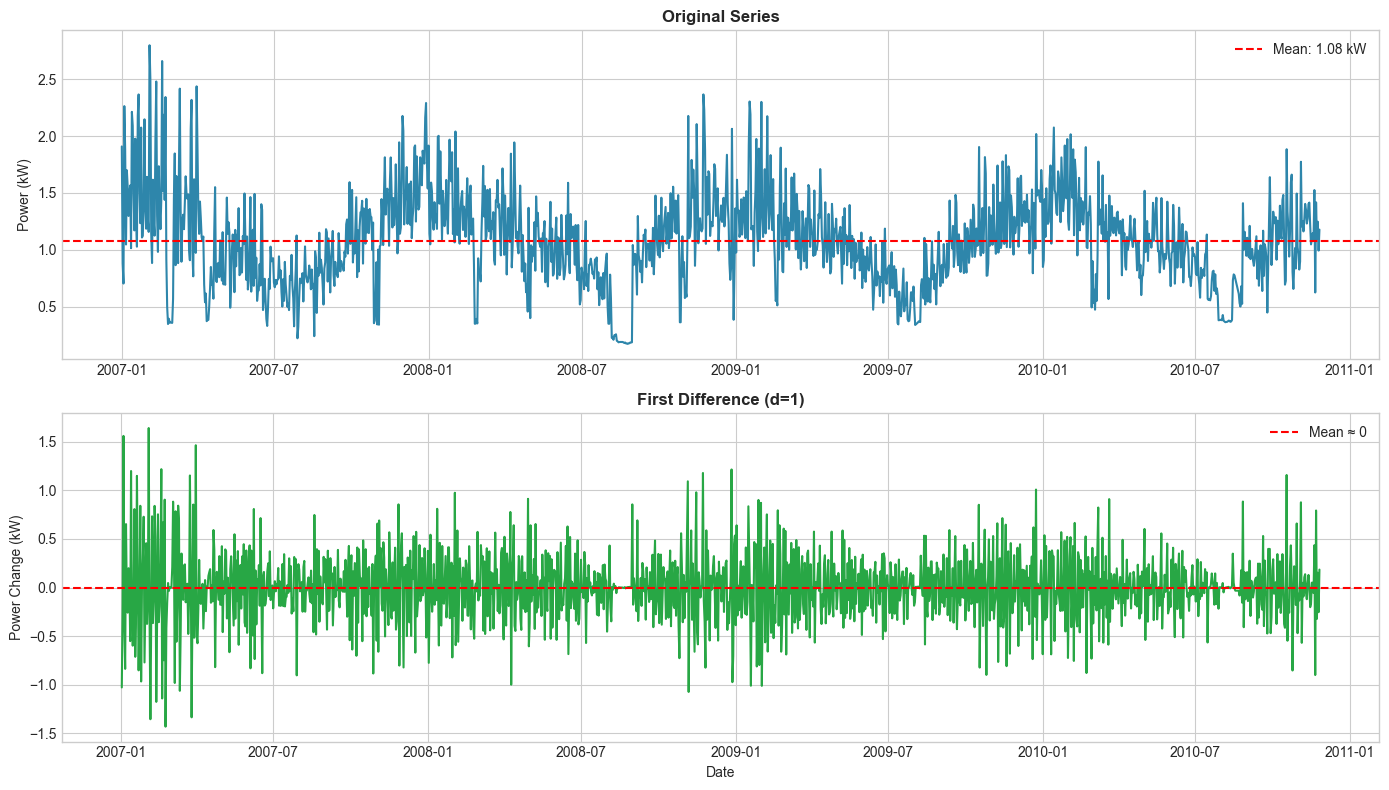


📌 CONCLUSION: Check if d=1 makes the series stationary for ARIMA


In [ ]:
# Visualize: Original vs Differenced
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original
axes[0].plot(ts.index, ts.values, color='#2E86AB')
axes[0].set_title('Original Series', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Power (kW)')
axes[0].axhline(y=ts.mean(), color='red', linestyle='--', label=f'Mean: {ts.mean():.2f} kW')
axes[0].legend()

# Differenced
axes[1].plot(ts_diff.index, ts_diff.values, color='#28A745')
axes[1].set_title('First Difference (d=1)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Power Change (kW)')
axes[1].axhline(y=0, color='red', linestyle='--', label='Mean ≈ 0')
axes[1].legend()
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

print("\nCONCLUSION: Check if d=1 makes the series stationary for ARIMA")

Rolling Statistics Visualization

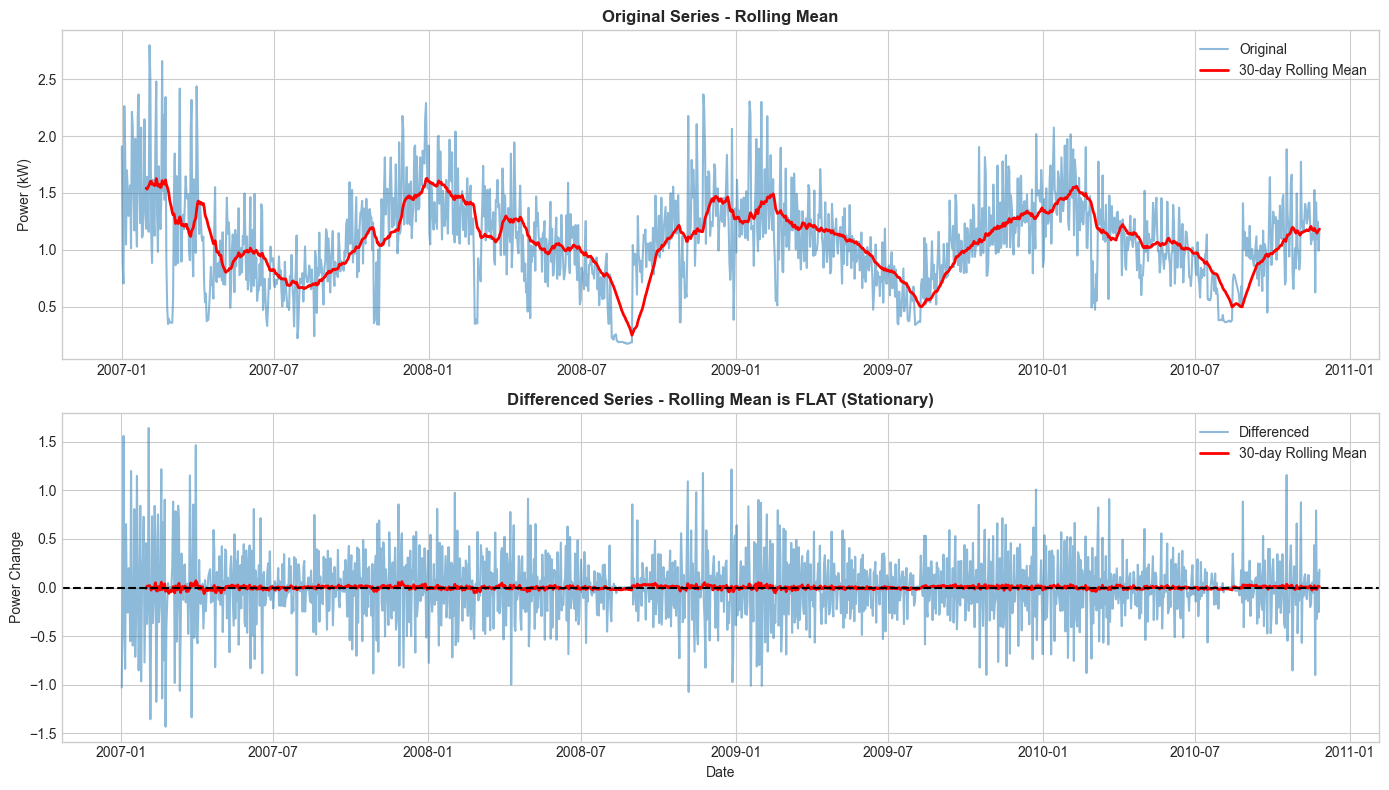

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original - Rolling Mean & Std
rolling_mean = ts.rolling(window=30).mean()
rolling_std = ts.rolling(window=30).std()

axes[0].plot(ts.index, ts.values, label='Original', alpha=0.5)
axes[0].plot(rolling_mean.index, rolling_mean.values, label='30-day Rolling Mean', color='red', linewidth=2)
axes[0].set_title('Original Series - Rolling Mean', fontweight='bold')
axes[0].legend()
axes[0].set_ylabel('Power (kW)')

# Differenced - Rolling Mean & Std
rolling_mean_diff = ts_diff.rolling(window=30).mean()

axes[1].plot(ts_diff.index, ts_diff.values, label='Differenced', alpha=0.5)
axes[1].plot(rolling_mean_diff.index, rolling_mean_diff.values, label='30-day Rolling Mean', color='red', linewidth=2)
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].set_title('Differenced Series - Rolling Mean is FLAT (Stationary)', fontweight='bold')
axes[1].legend()
axes[1].set_ylabel('Power Change')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

---
# STEP 2: ACF and PACF ANALYSIS
---

## What are ACF and PACF?

- **ACF (Autocorrelation Function)**: Correlation between the series and its lagged values
- **PACF (Partial Autocorrelation Function)**: Direct correlation at each lag

## Why we need them:
They help us choose **p** and **q** for ARIMA(p,d,q)

| Pattern | ACF | PACF | Model |
|---------|-----|------|-------|
| AR(p) | Tails off | Cuts off after lag p | Use PACF for p |
| MA(q) | Cuts off after lag q | Tails off | Use ACF for q |
| ARMA(p,q) | Tails off | Tails off | Need both |

## ACF/PACF Plots

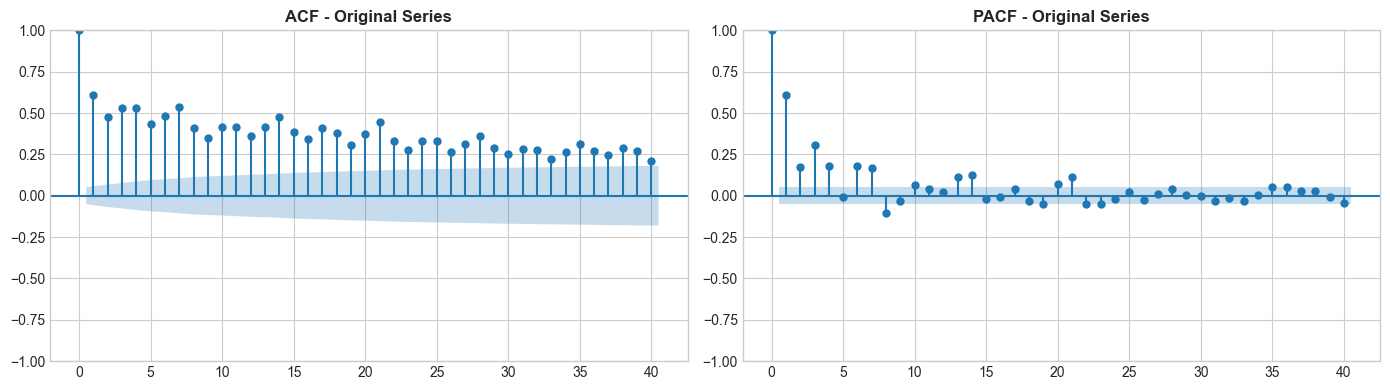

📌 Notice: ACF pattern shows the autocorrelation structure


In [ ]:
# ACF/PACF for ORIGINAL series
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(ts.dropna(), lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF - Original Series', fontweight='bold')

plot_pacf(ts.dropna(), lags=40, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('PACF - Original Series', fontweight='bold')

plt.tight_layout()
plt.show()

print("Notice: ACF pattern shows the autocorrelation structure")

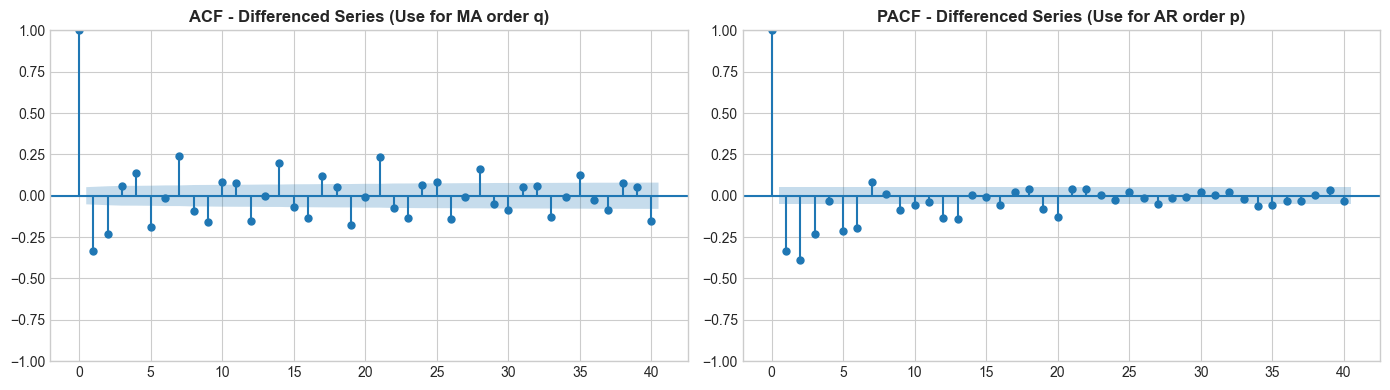

In [ ]:
# ACF/PACF for DIFFERENCED series
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(ts_diff.dropna(), lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF - Differenced Series (Use for MA order q)', fontweight='bold')

plot_pacf(ts_diff.dropna(), lags=40, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('PACF - Differenced Series (Use for AR order p)', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Interpretation
print("\n" + "="*50)
print("ACF/PACF INTERPRETATION")
print("="*50)
print("""
Looking at the DIFFERENCED series plots:

ACF Analysis:
   - Check for significant spikes outside confidence bands
   - Spikes suggest MA component (q value)
   - Look for seasonal patterns (spikes at lag 7 for weekly)

ACF Analysis:
   - Sharp cutoff suggests AR component (p value)
   - Number of significant lags = p

RECOMMENDED ARIMA ORDER:
   - p = 1 or 2 (from PACF)
   - d = 1 (from stationarity test)
   - q = 1 or 2 (from ACF)
   
   For SARIMA with weekly seasonality (s=7):
   Try: SARIMA(2,1,2)(1,1,1,7)
""")


ACF/PACF INTERPRETATION

Looking at the DIFFERENCED series plots:

📊 ACF Analysis:
   - Check for significant spikes outside confidence bands
   - Spikes suggest MA component (q value)
   - Look for seasonal patterns (spikes at lag 7 for weekly)

📊 PACF Analysis:
   - Sharp cutoff suggests AR component (p value)
   - Number of significant lags = p

📌 RECOMMENDED ARIMA ORDER:
   - p = 1 or 2 (from PACF)
   - d = 1 (from stationarity test)
   - q = 1 or 2 (from ACF)
   
   For SARIMA with weekly seasonality (s=7):
   Try: SARIMA(2,1,2)(1,1,1,7)



 Classical Decomposition (Additive)

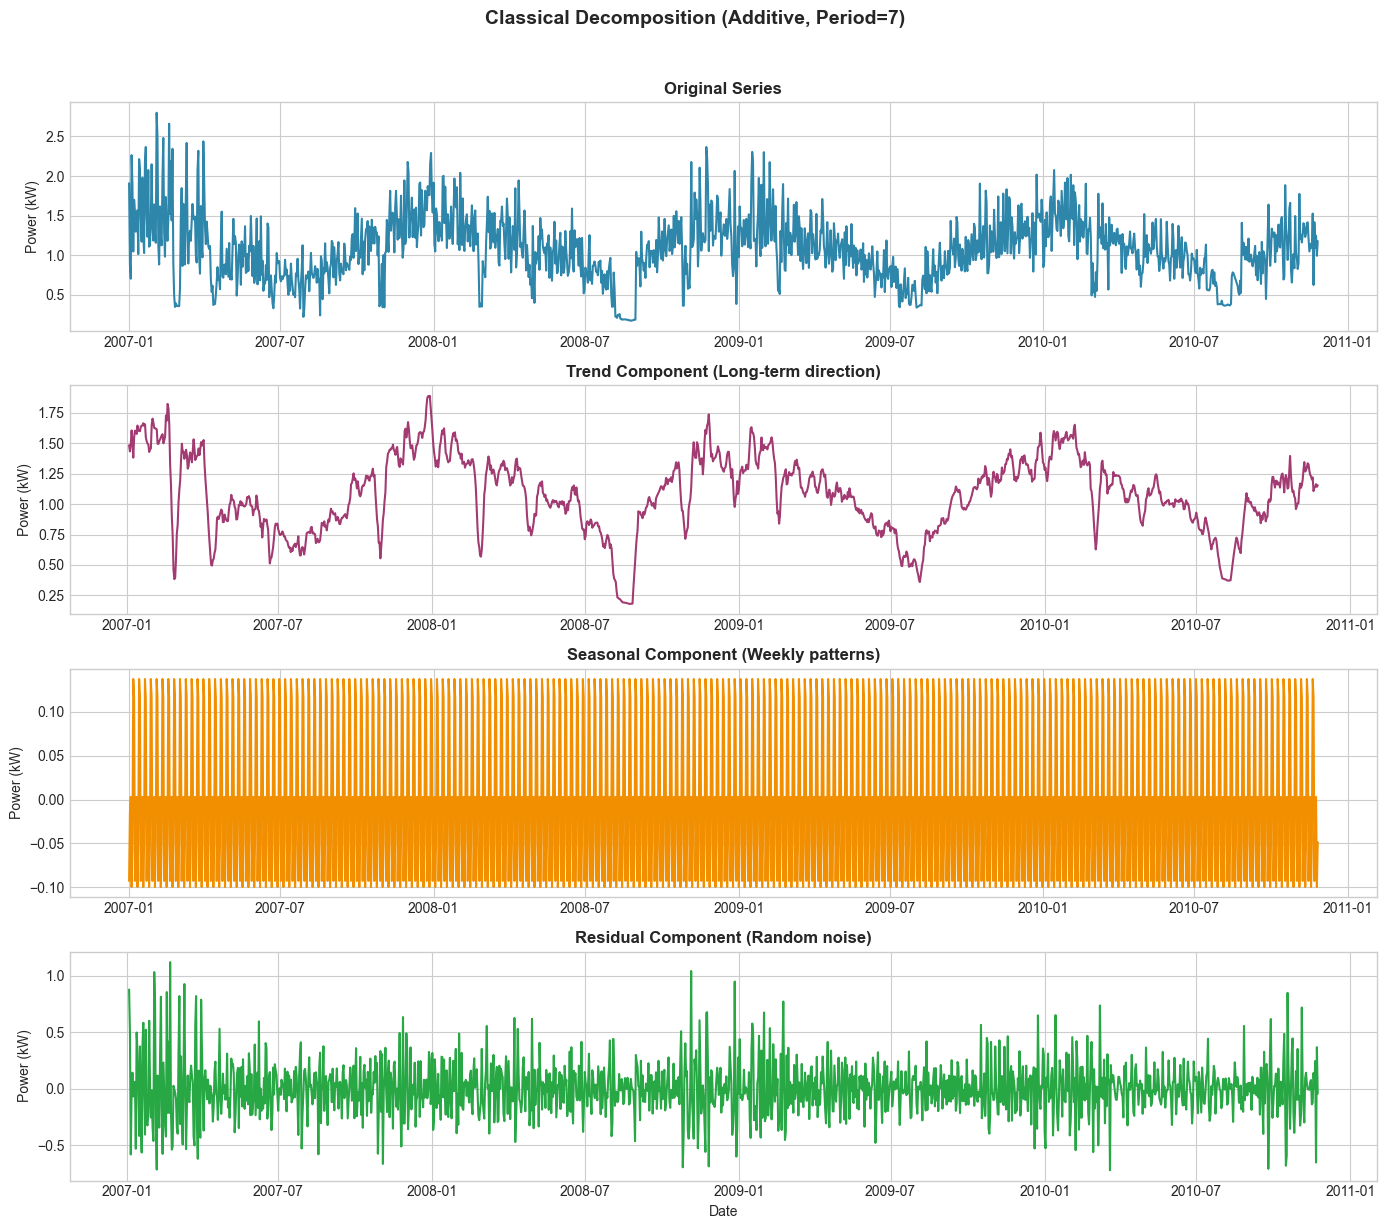

In [ ]:
# period=7 for weekly pattern
# period=30 for monthly pattern

decomp_period = 7  # Weekly seasonality

decomposition = seasonal_decompose(ts, model='additive', period=decomp_period)

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Original
axes[0].plot(ts.index, ts.values, color='#2E86AB')
axes[0].set_title('Original Series', fontweight='bold')
axes[0].set_ylabel('Power (kW)')

# Trend
axes[1].plot(decomposition.trend.index, decomposition.trend.values, color='#A23B72')
axes[1].set_title('Trend Component (Long-term direction)', fontweight='bold')
axes[1].set_ylabel('Power (kW)')

# Seasonal
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, color='#F18F01')
axes[2].set_title('Seasonal Component (Weekly patterns)', fontweight='bold')
axes[2].set_ylabel('Power (kW)')

# Residual
axes[3].plot(decomposition.resid.index, decomposition.resid.values, color='#28A745')
axes[3].set_title('Residual Component (Random noise)', fontweight='bold')
axes[3].set_ylabel('Power (kW)')
axes[3].set_xlabel('Date')

plt.suptitle(f'Classical Decomposition (Additive, Period={decomp_period})', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## STL Decomposition (More Robust)

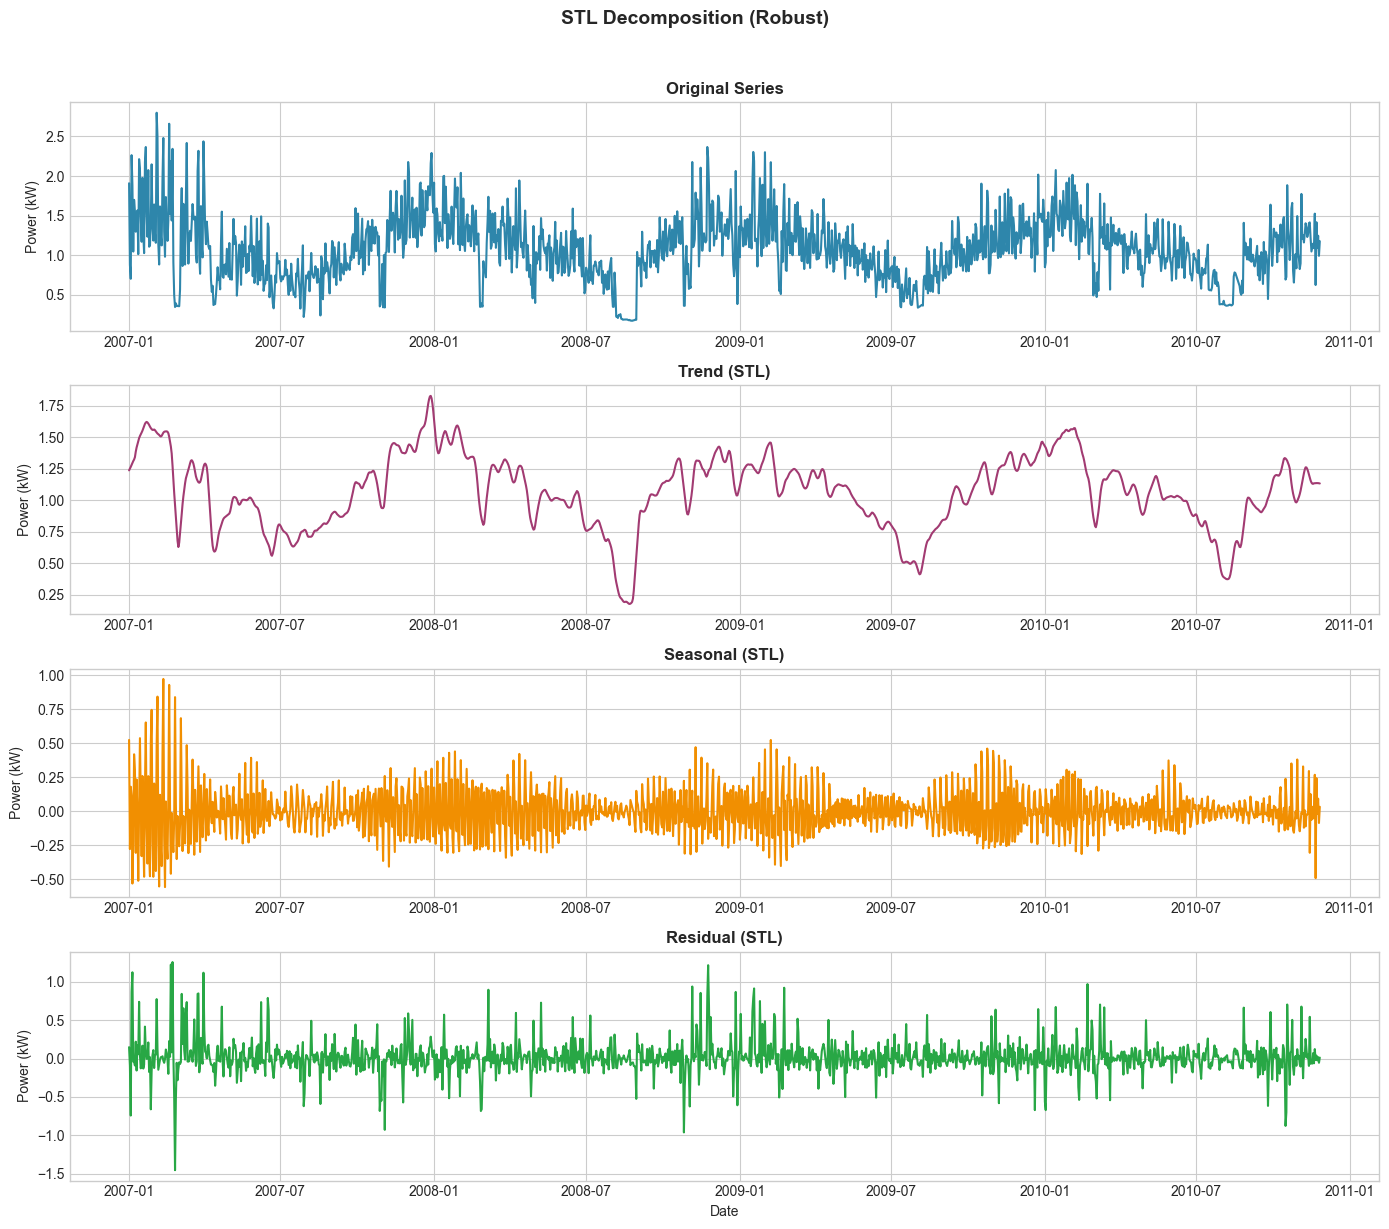

In [ ]:
# STL = Seasonal and Trend decomposition
# More robust to outliers than classical decomposition

stl = STL(ts, period=decomp_period, robust=True)
stl_result = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

axes[0].plot(ts.index, ts.values, color='#2E86AB')
axes[0].set_title('Original Series', fontweight='bold')
axes[0].set_ylabel('Power (kW)')

axes[1].plot(ts.index, stl_result.trend, color='#A23B72')
axes[1].set_title('Trend (STL)', fontweight='bold')
axes[1].set_ylabel('Power (kW)')

axes[2].plot(ts.index, stl_result.seasonal, color='#F18F01')
axes[2].set_title('Seasonal (STL)', fontweight='bold')
axes[2].set_ylabel('Power (kW)')

axes[3].plot(ts.index, stl_result.resid, color='#28A745')
axes[3].set_title('Residual (STL)', fontweight='bold')
axes[3].set_ylabel('Power (kW)')
axes[3].set_xlabel('Date')

plt.suptitle('STL Decomposition (Robust)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Decomposition Statistics
print("\n" + "="*50)
print("DECOMPOSITION SUMMARY")
print("="*50)

print(f"\nTrend:")
print(f"   Start: {stl_result.trend.dropna().iloc[0]:.3f} kW")
print(f"   End: {stl_result.trend.dropna().iloc[-1]:.3f} kW")
print(f"   Change: {stl_result.trend.dropna().iloc[-1] - stl_result.trend.dropna().iloc[0]:.3f} kW")

print(f"\nSeasonal:")
print(f"   Range: {stl_result.seasonal.min():.3f} to {stl_result.seasonal.max():.3f} kW")
print(f"   (This shows weekly variation in energy use)")

print(f"\nResidual:")
print(f"   Mean: {stl_result.resid.mean():.4f} (should be ~0)")
print(f"   Std: {stl_result.resid.std():.3f} kW")


DECOMPOSITION SUMMARY

📈 Trend:
   Start: 1.237 kW
   End: 1.133 kW
   Change: -0.104 kW

🔄 Seasonal:
   Range: -0.556 to 0.973 kW
   (This shows weekly variation in energy use)

🎲 Residual:
   Mean: 0.0174 (should be ~0)
   Std: 0.220 kW


In [ ]:
# Calculate strength of components
var_resid = np.var(stl_result.resid.dropna())
var_trend_resid = np.var(stl_result.trend.dropna() + stl_result.resid.dropna())
var_seasonal_resid = np.var(stl_result.seasonal + stl_result.resid.dropna())

strength_trend = max(0, 1 - var_resid / var_trend_resid)
strength_seasonal = max(0, 1 - var_resid / var_seasonal_resid)

print(f"\n📊 Component Strength (0 to 1):")
print(f"   Trend Strength: {strength_trend:.4f} {'(Strong)' if strength_trend > 0.5 else '(Weak)'}")
print(f"   Seasonal Strength: {strength_seasonal:.4f} {'(Strong)' if strength_seasonal > 0.5 else '(Weak)'}")

if strength_seasonal > 0.3:
    print("\nRecommendation: Use SARIMA (seasonal patterns detected)")
else:
    print("\nRecommendation: ARIMA may be sufficient")


📊 Component Strength (0 to 1):
   Trend Strength: 0.6618 (Strong)
   Seasonal Strength: 0.3145 (Weak)

📌 Recommendation: Use SARIMA (seasonal patterns detected)


---
## Summary: What We Learned

### 1. Stationarity:
- Tested original series with ADF test
- Applied differencing if needed
- Determined **d** value for ARIMA

### 2. ACF/PACF:
- Identified **p** and **q** values for ARIMA
- Checked for seasonal patterns at lag 7 (weekly)

### 3. Decomposition:
- **Trend**: Long-term energy consumption pattern
- **Seasonal**: Weekly usage patterns (weekday vs weekend)
- **Residual**: Random variations and potential anomalies

### Next Steps (Part 3):
- Anomaly Detection (Z-score, Isolation Forest)
- Data Cleaning
- Re-Forecasting with cleaned data
- Final Comparison: Before vs After

---

---
# ANOMALY DETECTION
---

## What is an Anomaly?
An **anomaly** (outlier) is a data point significantly different from other observations.

In energy data, anomalies could be:
- Power outages (sudden drops)
- Equipment malfunction (unusual spikes)
- Sensor errors
- Special events (holidays, vacations)

---

## Method 1: Z-Score (Statistical)

In [36]:
def detect_anomalies_zscore(series, threshold=3):
    """
    Detect anomalies using Z-score method
    Z = (x - mean) / std
    If |Z| > threshold, it's an anomaly
    """
    z_scores = np.abs(stats.zscore(series.dropna()))
    anomalies = z_scores > threshold
    return anomalies, z_scores

print("Z-Score function defined!")

Z-Score function defined!


In [37]:
# Apply Z-Score to energy consumption
zscore_anomalies, z_scores = detect_anomalies_zscore(ts, threshold=3)

# Get anomaly dates and values
zscore_anomaly_dates = ts.dropna().index[zscore_anomalies]
zscore_anomaly_values = ts[zscore_anomaly_dates]

print("="*50)
print("Z-SCORE ANOMALY DETECTION RESULTS")
print("="*50)
print(f"\nThreshold: 3 standard deviations")
print(f"Total data points: {len(ts)}")
print(f"Anomalies found: {len(zscore_anomaly_dates)}")
print(f"\nAnomalous dates and values:")
for date, value in zip(zscore_anomaly_dates[:10], zscore_anomaly_values[:10]):
    print(f"  {date.date()}: {value:.3f} kW")

Z-SCORE ANOMALY DETECTION RESULTS

Threshold: 3 standard deviations
Total data points: 1426
Anomalies found: 11

Anomalous dates and values:
  2007-01-21: 2.366 kW
  2007-02-03: 2.798 kW
  2007-02-04: 2.497 kW
  2007-02-11: 2.480 kW
  2007-02-18: 2.660 kW
  2007-02-22: 2.343 kW
  2007-03-11: 2.417 kW
  2007-03-25: 2.318 kW
  2007-03-31: 2.437 kW
  2008-11-23: 2.366 kW


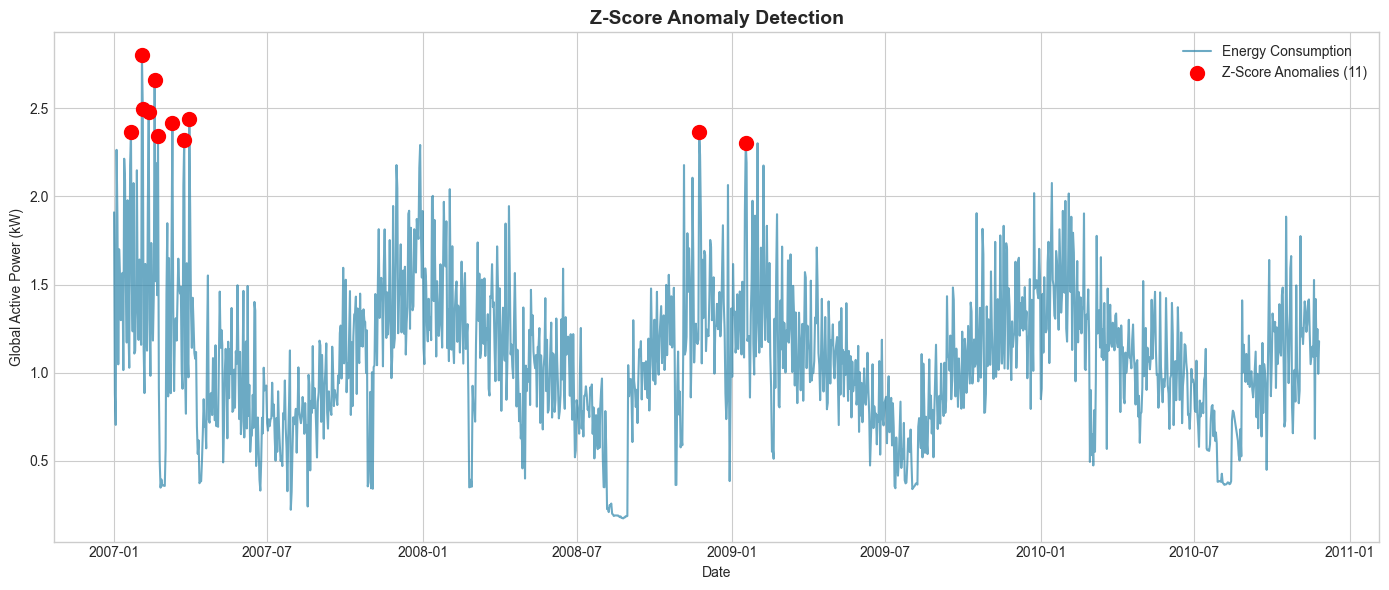

In [38]:
# Visualize Z-Score Anomalies
plt.figure(figsize=(14, 6))

plt.plot(ts.index, ts.values, color='#2E86AB', label='Energy Consumption', alpha=0.7)
plt.scatter(zscore_anomaly_dates, zscore_anomaly_values, 
            color='red', s=100, zorder=5, label=f'Z-Score Anomalies ({len(zscore_anomaly_dates)})')

plt.title('Z-Score Anomaly Detection', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

---
## Method 2: Isolation Forest (Machine Learning)

In [39]:
# Prepare features for Isolation Forest
df_features = pd.DataFrame({'power': ts})
df_features['power_diff'] = df_features['power'].diff()
df_features['rolling_mean_7'] = df_features['power'].rolling(7).mean()
df_features['rolling_std_7'] = df_features['power'].rolling(7).std()
df_features['day_of_week'] = df_features.index.dayofweek

# Drop NaN
df_features = df_features.dropna()

# Select features
features = ['power', 'power_diff', 'rolling_std_7']
X = df_features[features].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features prepared: {X_scaled.shape}")
print(f"Features used: {features}")

Features prepared: (1420, 3)
Features used: ['power', 'power_diff', 'rolling_std_7']


In [40]:
# Fit Isolation Forest
iso_forest = IsolationForest(
    contamination=0.02,  # Expect ~2% anomalies
    random_state=42,
    n_estimators=100
)

# Predict: -1 = anomaly, 1 = normal
iso_predictions = iso_forest.fit_predict(X_scaled)
iso_scores = iso_forest.decision_function(X_scaled)

# Get anomalies
iso_anomalies = iso_predictions == -1
iso_anomaly_dates = df_features.index[iso_anomalies]
iso_anomaly_values = df_features.loc[iso_anomaly_dates, 'power']

print("="*50)
print("ISOLATION FOREST ANOMALY DETECTION RESULTS")
print("="*50)
print(f"\nContamination: 2%")
print(f"Total data points: {len(df_features)}")
print(f"Anomalies found: {iso_anomalies.sum()}")
print(f"\nSample anomalous dates:")
for date in iso_anomaly_dates[:10]:
    power = df_features.loc[date, 'power']
    print(f"  {date.date()}: {power:.3f} kW")

ISOLATION FOREST ANOMALY DETECTION RESULTS

Contamination: 2%
Total data points: 1420
Anomalies found: 29

Sample anomalous dates:
  2007-01-13: 2.213 kW
  2007-01-20: 2.176 kW
  2007-01-21: 2.366 kW
  2007-02-03: 2.798 kW
  2007-02-04: 2.497 kW
  2007-02-05: 1.143 kW
  2007-02-07: 1.617 kW
  2007-02-11: 2.480 kW
  2007-02-12: 1.304 kW
  2007-02-18: 2.660 kW


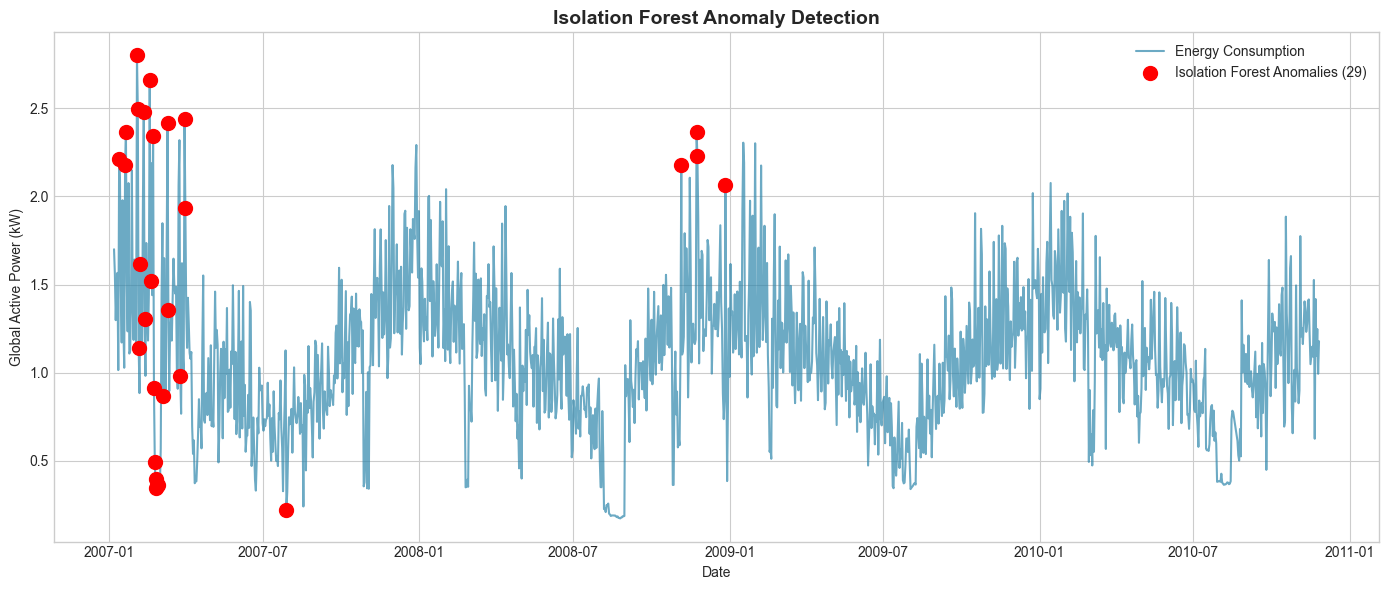

In [41]:
# Visualize Isolation Forest Anomalies
plt.figure(figsize=(14, 6))

plt.plot(df_features.index, df_features['power'], color='#2E86AB', label='Energy Consumption', alpha=0.7)
plt.scatter(iso_anomaly_dates, iso_anomaly_values,
            color='red', s=100, zorder=5, label=f'Isolation Forest Anomalies ({len(iso_anomaly_dates)})')

plt.title('Isolation Forest Anomaly Detection', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

## METHOD 3: STL RESIDUAL-BASED ANOMALY DETECTION

STL RESIDUAL ANOMALY DETECTION

Threshold: 3 standard deviations on residuals
Total data points: 1426
Anomalies found: 40


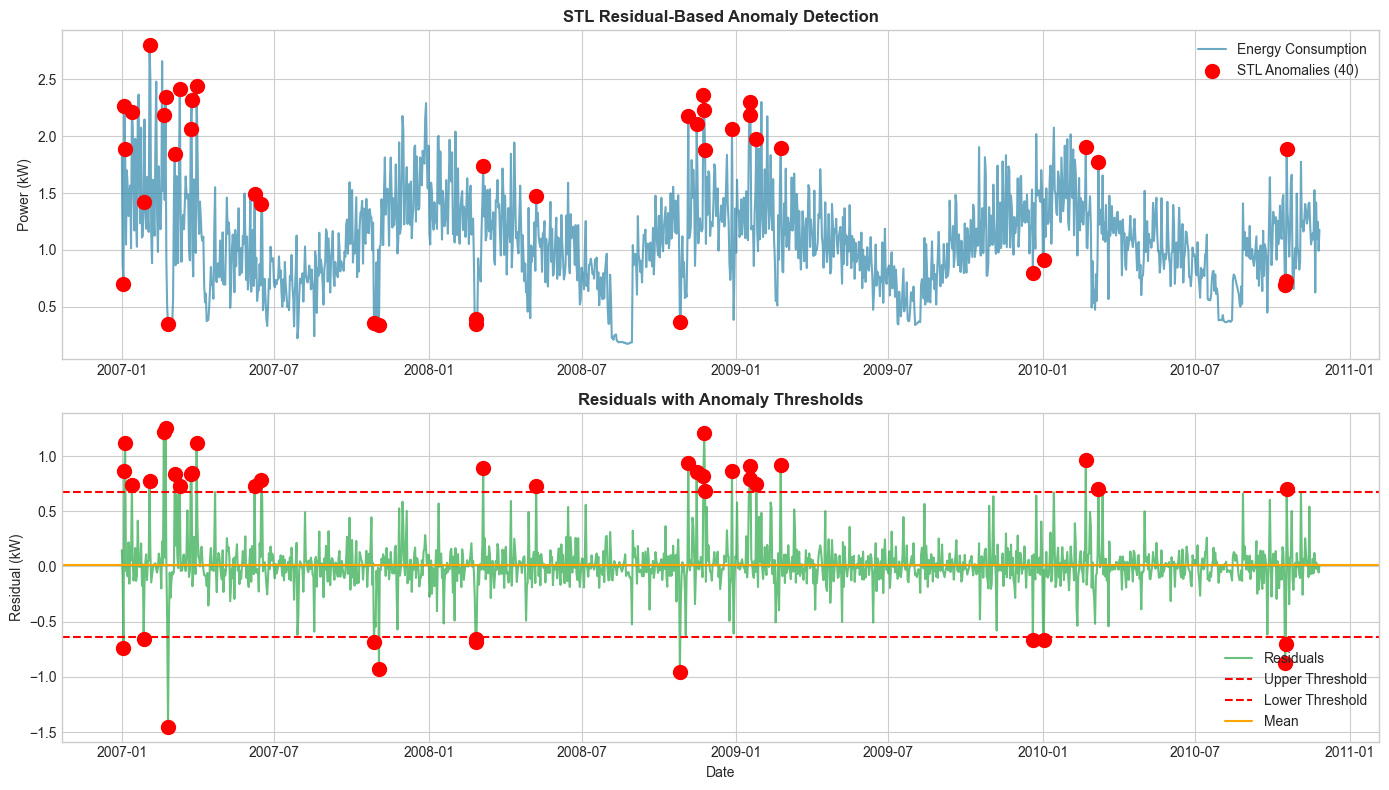


📌 STL Method detects anomalies in RESIDUALS (after removing trend & seasonality)


In [ ]:
print("=" * 50)
print("STL RESIDUAL ANOMALY DETECTION")
print("=" * 50)

# Decompose the time series
stl = STL(ts, period=7, robust=True)
stl_result = stl.fit()

# Get residuals
residuals = stl_result.resid

# Detect anomalies in RESIDUALS
residual_mean = residuals.mean()
residual_std = residuals.std()
threshold = 3

# Anomaly if residual is beyond 3 std from mean
stl_anomalies = np.abs(residuals - residual_mean) > (threshold * residual_std)
stl_anomaly_dates = ts.index[stl_anomalies]
stl_anomaly_values = ts[stl_anomalies]

print(f"\nThreshold: {threshold} standard deviations on residuals")
print(f"Total data points: {len(ts)}")
print(f"Anomalies found: {stl_anomalies.sum()}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original with anomalies
axes[0].plot(ts.index, ts.values, color='#2E86AB', alpha=0.7, label='Energy Consumption')
axes[0].scatter(stl_anomaly_dates, stl_anomaly_values, 
                color='red', s=100, zorder=5, label=f'STL Anomalies ({stl_anomalies.sum()})')
axes[0].set_title('STL Residual-Based Anomaly Detection', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Power (kW)')
axes[0].legend()

# Residuals with threshold lines
axes[1].plot(residuals.index, residuals.values, color='#28A745', alpha=0.7, label='Residuals')
axes[1].axhline(y=residual_mean + threshold*residual_std, color='red', linestyle='--', label='Upper Threshold')
axes[1].axhline(y=residual_mean - threshold*residual_std, color='red', linestyle='--', label='Lower Threshold')
axes[1].axhline(y=residual_mean, color='orange', linestyle='-', label='Mean')
axes[1].scatter(residuals.index[stl_anomalies], residuals.values[stl_anomalies], 
                color='red', s=100, zorder=5)
axes[1].set_title('Residuals with Anomaly Thresholds', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residual (kW)')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nSTL Method detects anomalies in RESIDUALS (after removing trend & seasonality)")

## METHOD 4: PROPHET-BASED ANOMALY DETECTION


PROPHET-BASED ANOMALY DETECTION

Fitting Prophet model...


06:10:32 - cmdstanpy - INFO - Chain [1] start processing
06:10:32 - cmdstanpy - INFO - Chain [1] done processing



Prediction Interval: 95%
Total data points: 1426
Anomalies found: 87


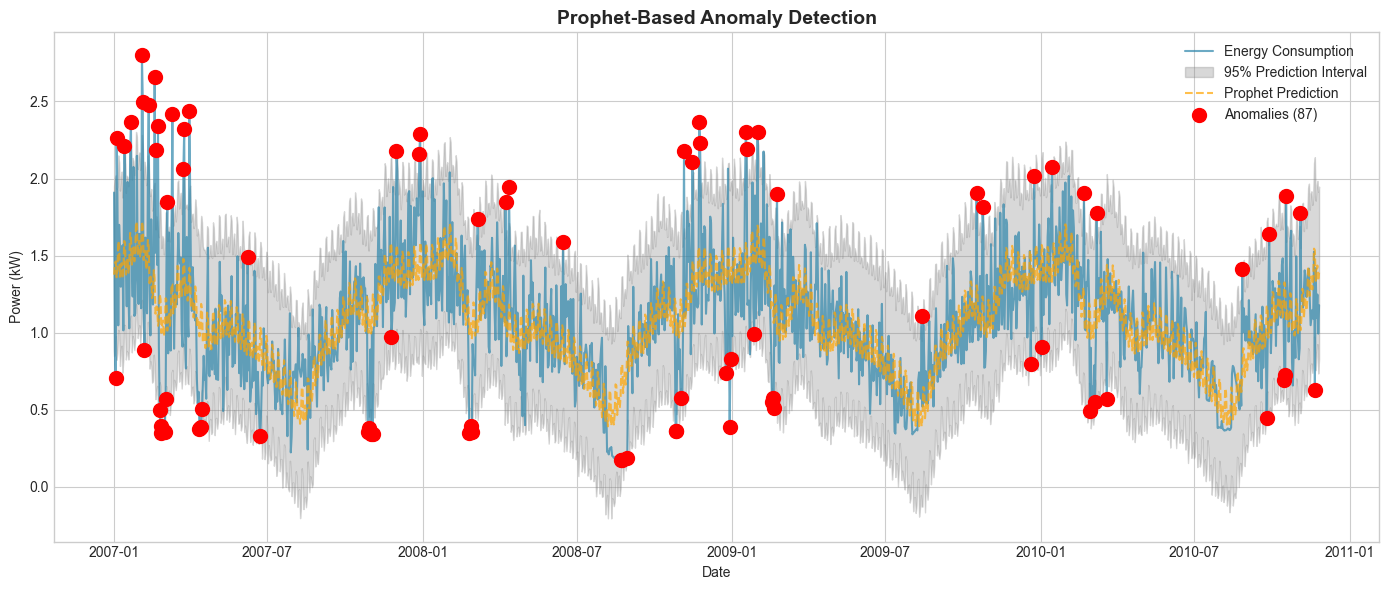


📌 Prophet Method detects values OUTSIDE the 95% prediction interval


In [ ]:
print("\n" + "=" * 50)
print("PROPHET-BASED ANOMALY DETECTION")
print("=" * 50)

# Prepare data for Prophet
df_prophet = pd.DataFrame({'ds': ts.index, 'y': ts.values})

# Fit Prophet model with 95% prediction interval
print("\nFitting Prophet model...")
model_anomaly = Prophet(interval_width=0.95, daily_seasonality=False, 
                        weekly_seasonality=True, yearly_seasonality=True)
model_anomaly.fit(df_prophet)

# Get predictions with intervals
forecast_anomaly = model_anomaly.predict(df_prophet)

# Anomaly = value outside prediction interval
forecast_anomaly['y'] = df_prophet['y'].values

# Create boolean array for anomalies
prophet_anomalies_bool = (forecast_anomaly['y'] > forecast_anomaly['yhat_upper']) | \
                         (forecast_anomaly['y'] < forecast_anomaly['yhat_lower'])

# Get anomaly dates and values using iloc (position-based)
prophet_anomaly_dates = ts.index[prophet_anomalies_bool.values]
prophet_anomaly_values = ts.iloc[prophet_anomalies_bool.values]

print(f"\nPrediction Interval: 95%")
print(f"Total data points: {len(ts)}")
print(f"Anomalies found: {prophet_anomalies_bool.sum()}")

# 5. Visualize
plt.figure(figsize=(14, 6))
plt.plot(ts.index, ts.values, color='#2E86AB', alpha=0.7, label='Energy Consumption')
plt.fill_between(ts.index, forecast_anomaly['yhat_lower'].values, forecast_anomaly['yhat_upper'].values, 
                 alpha=0.3, color='gray', label='95% Prediction Interval')
plt.plot(ts.index, forecast_anomaly['yhat'].values, color='orange', linestyle='--', 
         alpha=0.7, label='Prophet Prediction')
plt.scatter(prophet_anomaly_dates, prophet_anomaly_values, 
            color='red', s=100, zorder=5, label=f'Anomalies ({prophet_anomalies_bool.sum()})')
plt.title('Prophet-Based Anomaly Detection', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nProphet Method detects values OUTSIDE the 95% prediction interval")

---
## COMPARE ALL 4 ANOMALY DETECTION METHODS


       ANOMALY DETECTION METHODS COMPARISON




Method              Type  Anomalies Found Considers Seasonality
0           Z-Score       Statistical               11                    No
1  Isolation Forest  Machine Learning               29                    No
2      STL Residual     Decomposition               40                   Yes
3  Prophet Interval       Forecasting               87                   Yes

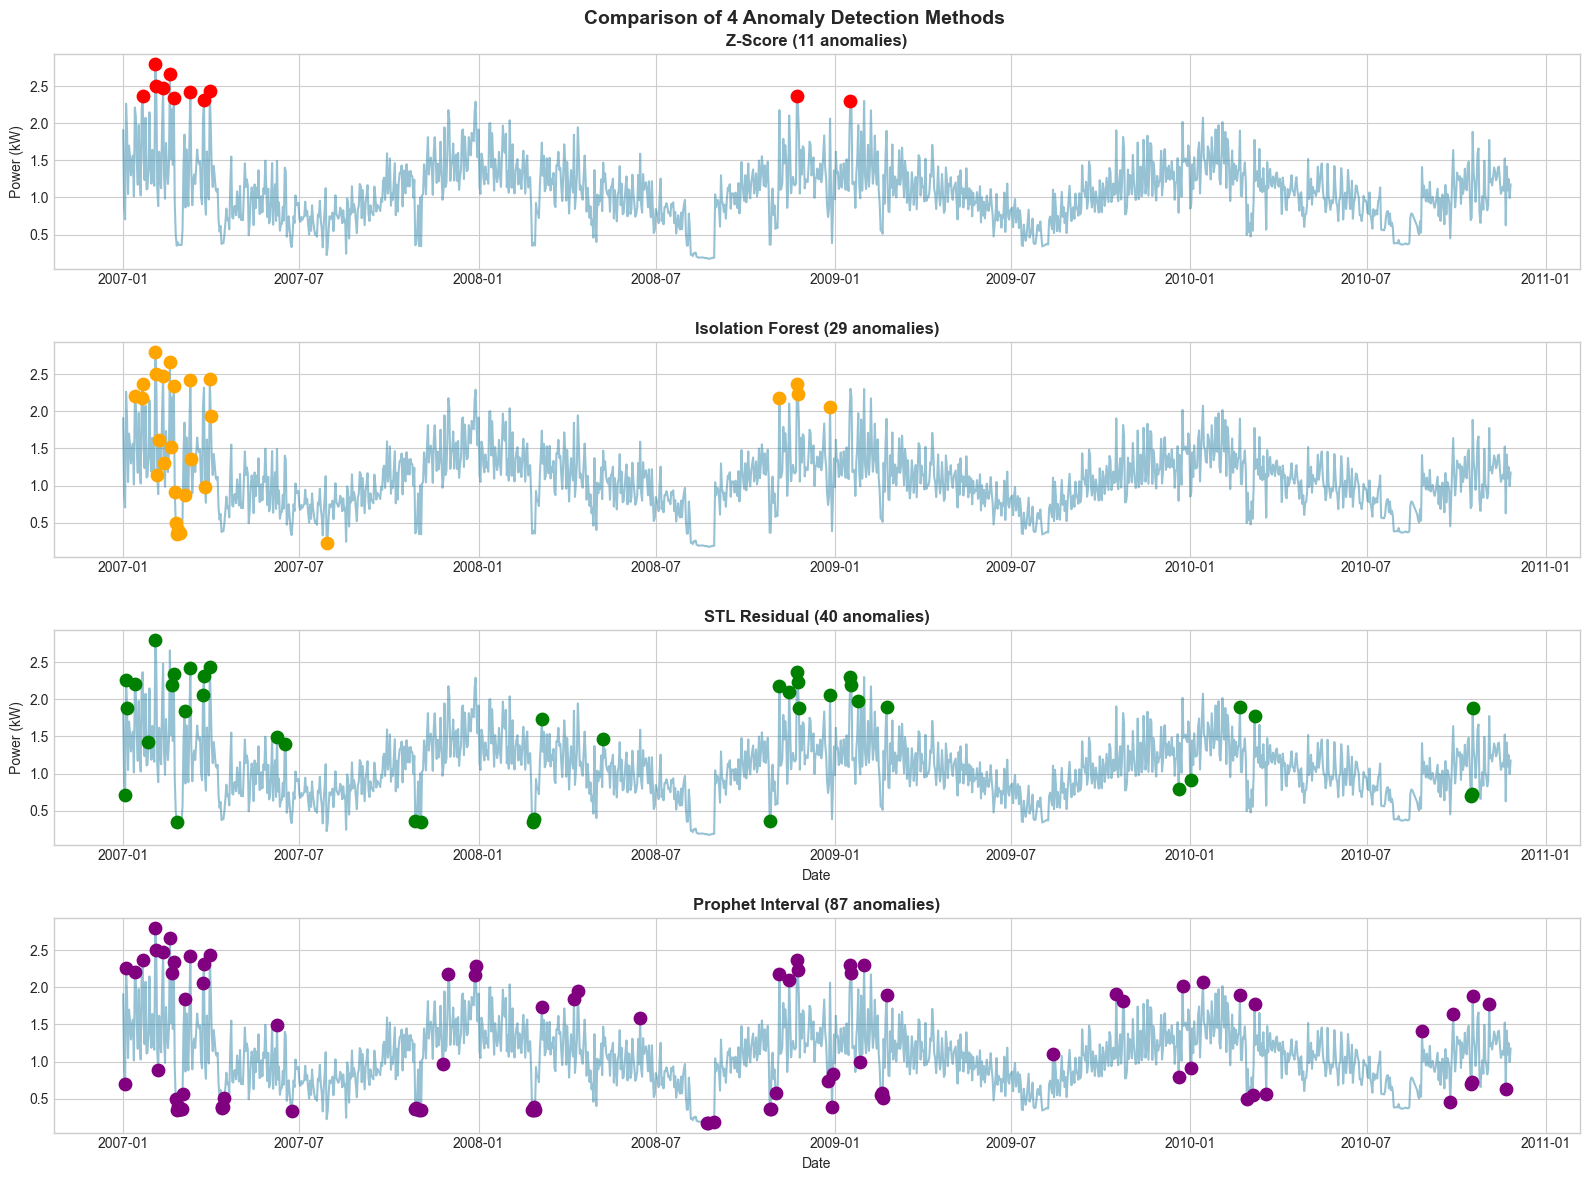


OVERLAP ANALYSIS

Anomalies detected by 2+ methods: 42 (High Confidence)
Anomalies detected by only 1 method: 63


In [45]:
print("\n" + "=" * 60)
print("       ANOMALY DETECTION METHODS COMPARISON")
print("=" * 60)

# Summary table
comparison_data = {
    'Method': ['Z-Score', 'Isolation Forest', 'STL Residual', 'Prophet Interval'],
    'Type': ['Statistical', 'Machine Learning', 'Decomposition', 'Forecasting'],
    'Anomalies Found': [len(zscore_anomaly_dates), len(iso_anomaly_dates), 
                        stl_anomalies.sum(), prophet_anomalies_bool.sum()],
    'Considers Seasonality': ['No', 'No', 'Yes', 'Yes']
}

comparison_df = pd.DataFrame(comparison_data)
print("\n")
display(comparison_df)

# Visualize all methods together
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Z-Score
axes[0].plot(ts.index, ts.values, color='#2E86AB', alpha=0.5)
axes[0].scatter(zscore_anomaly_dates, zscore_anomaly_values, color='red', s=80, zorder=5)
axes[0].set_title(f'Z-Score ({len(zscore_anomaly_dates)} anomalies)', fontweight='bold')
axes[0].set_ylabel('Power (kW)')

# Isolation Forest
axes[1].plot(ts.index, ts.values, color='#2E86AB', alpha=0.5)
axes[1].scatter(iso_anomaly_dates, ts[iso_anomaly_dates], color='orange', s=80, zorder=5)
axes[1].set_title(f'Isolation Forest ({len(iso_anomaly_dates)} anomalies)', fontweight='bold')

# STL Residual
axes[2].plot(ts.index, ts.values, color='#2E86AB', alpha=0.5)
axes[2].scatter(stl_anomaly_dates, stl_anomaly_values, color='green', s=80, zorder=5)
axes[2].set_title(f'STL Residual ({stl_anomalies.sum()} anomalies)', fontweight='bold')
axes[2].set_ylabel('Power (kW)')
axes[2].set_xlabel('Date')

# Prophet
axes[3].plot(ts.index, ts.values, color='#2E86AB', alpha=0.5)
axes[3].scatter(prophet_anomaly_dates, prophet_anomaly_values, color='purple', s=80, zorder=5)
axes[3].set_title(f'Prophet Interval ({prophet_anomalies_bool.sum()} anomalies)', fontweight='bold')
axes[3].set_xlabel('Date')

plt.suptitle('Comparison of 4 Anomaly Detection Methods', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find common anomalies (detected by multiple methods)
print("\n" + "=" * 50)
print("OVERLAP ANALYSIS")
print("=" * 50)

all_methods_dates = [set(zscore_anomaly_dates), set(iso_anomaly_dates), 
                     set(stl_anomaly_dates), set(prophet_anomaly_dates)]

# Anomalies detected by at least 2 methods
from functools import reduce
all_dates = reduce(lambda x, y: x.union(y), all_methods_dates)

overlap_count = {}
for date in all_dates:
    count = sum(1 for method_dates in all_methods_dates if date in method_dates)
    overlap_count[date] = count

high_confidence = [date for date, count in overlap_count.items() if count >= 2]
print(f"\nAnomalies detected by 2+ methods: {len(high_confidence)} (High Confidence)")
print(f"Anomalies detected by only 1 method: {len(all_dates) - len(high_confidence)}")

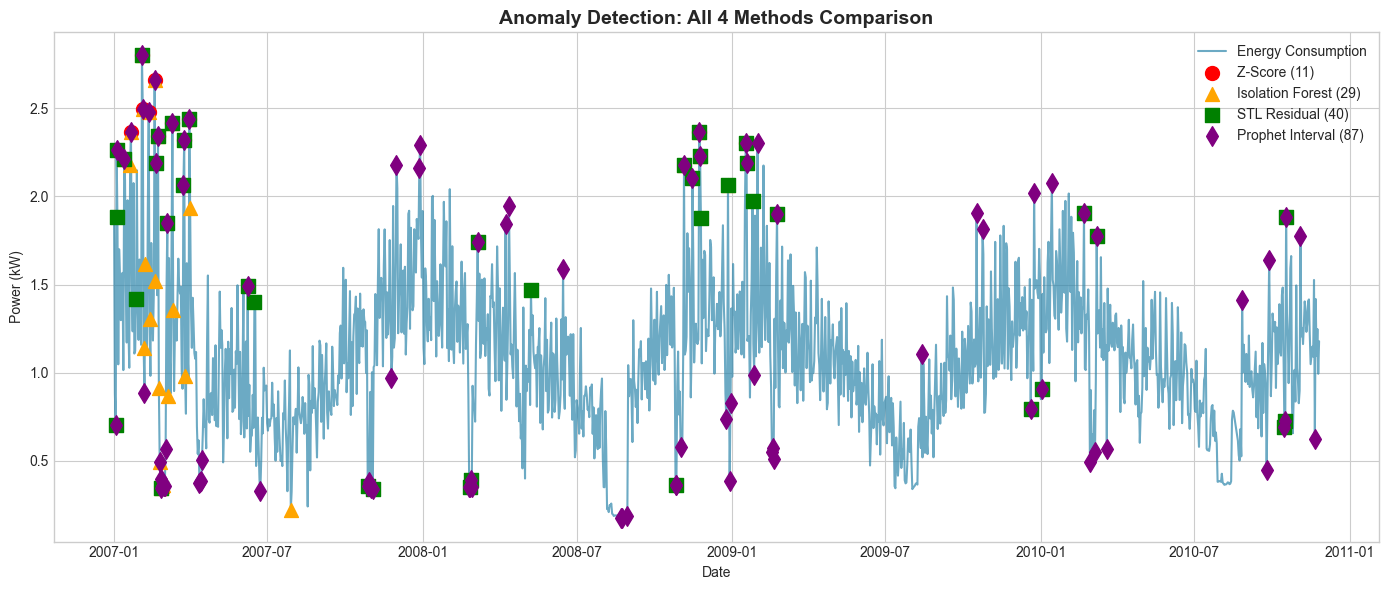

In [46]:
# Visualize all 4 methods together
plt.figure(figsize=(14, 6))

plt.plot(ts.index, ts.values, color='#2E86AB', alpha=0.7, label='Energy Consumption')

plt.scatter(zscore_anomaly_dates, ts[zscore_anomaly_dates], 
            color='red', s=100, marker='o', label=f'Z-Score ({len(zscore_anomaly_dates)})', zorder=5)

plt.scatter(iso_anomaly_dates, ts[iso_anomaly_dates], 
            color='orange', s=100, marker='^', label=f'Isolation Forest ({len(iso_anomaly_dates)})', zorder=5)

plt.scatter(stl_anomaly_dates, stl_anomaly_values, 
            color='green', s=100, marker='s', label=f'STL Residual ({stl_anomalies.sum()})', zorder=5)

plt.scatter(prophet_anomaly_dates, prophet_anomaly_values, 
            color='purple', s=100, marker='d', label=f'Prophet Interval ({prophet_anomalies_bool.sum()})', zorder=5)

plt.title('Anomaly Detection: All 4 Methods Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

---
# DATA CLEANING
---

In [ ]:
# Clean data by imputing anomalies
ts_cleaned = ts.copy()

# Use STL Residual anomalies for cleaning (best method)
anomalies_to_clean = stl_anomaly_dates

print(f"Cleaning {len(anomalies_to_clean)} anomalies using STL Residual method...")

# Replace anomalies with NaN, then interpolate
ts_cleaned.loc[anomalies_to_clean] = np.nan
ts_cleaned = ts_cleaned.interpolate(method='linear')
ts_cleaned = ts_cleaned.ffill().bfill()

print(f"\nData cleaned!")
print(f"   Original mean: {ts.mean():.3f} kW")
print(f"   Cleaned mean: {ts_cleaned.mean():.3f} kW")
print(f"   Original std: {ts.std():.3f} kW")
print(f"   Cleaned std: {ts_cleaned.std():.3f} kW")
print(f"   Anomalies removed: {len(anomalies_to_clean)}")

Cleaning 40 anomalies using STL Residual method...

✅ Data cleaned!
   Original mean: 1.081 kW
   Cleaned mean: 1.068 kW
   Original std: 0.407 kW
   Cleaned std: 0.381 kW
   Anomalies removed: 40


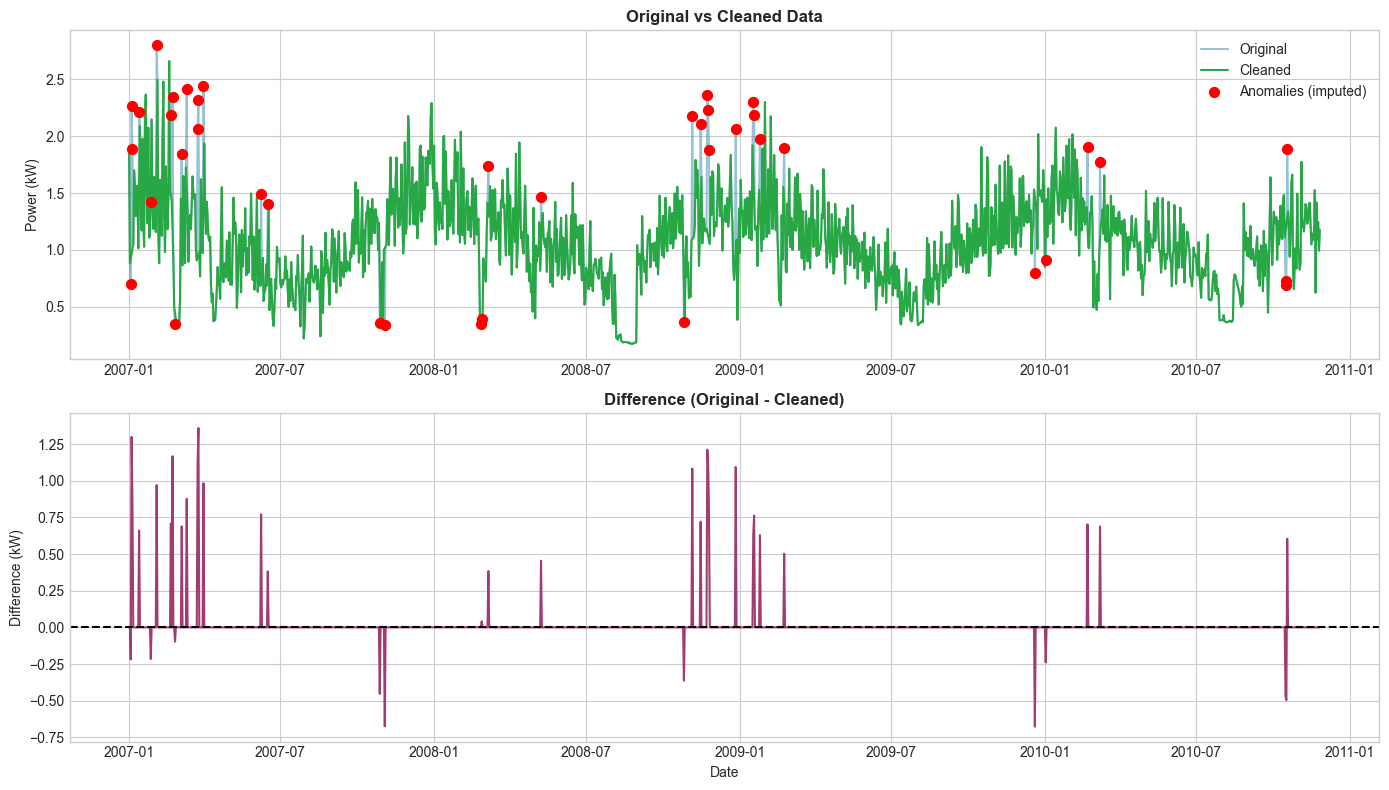

In [48]:
# Visualize Original vs Cleaned
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(ts.index, ts.values, color='#2E86AB', alpha=0.5, label='Original')
axes[0].plot(ts_cleaned.index, ts_cleaned.values, color='#28A745', label='Cleaned')
axes[0].scatter(anomalies_to_clean, ts[anomalies_to_clean], 
                color='red', s=50, label='Anomalies (imputed)', zorder=5)
axes[0].set_title('Original vs Cleaned Data', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Power (kW)')
axes[0].legend()

diff = ts - ts_cleaned
axes[1].plot(diff.index, diff.values, color='#A23B72')
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].set_title('Difference (Original - Cleaned)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Difference (kW)')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

---
# RE-FORECASTING AFTER CLEANING
---

In [49]:
def evaluate_forecast(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"\n{model_name}:")
    print(f"  MAE:  {mae:.4f} kW")
    print(f"  RMSE: {rmse:.4f} kW")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

In [50]:
# Train-Test Split
train_size = int(len(ts) * 0.8)

# Original data split
train_original = ts[:train_size]
test_original = ts[train_size:]

# Cleaned data split
train_cleaned = ts_cleaned[:train_size]
test_cleaned = ts_cleaned[train_size:]

print(f"Training size: {train_size}")
print(f"Test size: {len(test_original)}")

Training size: 1140
Test size: 286


In [ ]:
# SARIMA - Before (Original Data)
print("="*50)
print("SARIMA - BEFORE CLEANING")
print("="*50)

p, d, q = 1, 0, 4
P, D, Q, s = 1, 0, 1, 7

sarima_model_orig = SARIMAX(train_original, order=(p, d, q), seasonal_order=(P, D, Q, s),
                            enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_orig = sarima_model_orig.fit(disp=False)
sarima_forecast_orig = sarima_fit_orig.forecast(steps=len(test_original))
sarima_forecast_orig.index = test_original.index

sarima_metrics_before = evaluate_forecast(test_original.values, sarima_forecast_orig.values, 'SARIMA (Before)')

SARIMA - BEFORE CLEANING

SARIMA (Before):
  MAE:  0.3104 kW
  RMSE: 0.4197 kW
  MAPE: 33.20%


In [415]:
# SARIMA - After (Cleaned Data)
print("="*50)
print("SARIMA - AFTER CLEANING")
print("="*50)

sarima_model_clean = SARIMAX(train_cleaned, order=(p, d, q), seasonal_order=(P, D, Q, s),
                             enforce_stationarity=False, enforce_invertibility=False)
sarima_fit_clean = sarima_model_clean.fit(disp=False)
sarima_forecast_clean = sarima_fit_clean.forecast(steps=len(test_original))
sarima_forecast_clean.index = test_original.index

sarima_metrics_after = evaluate_forecast(test_original.values, sarima_forecast_clean.values, 'SARIMA (After)')

SARIMA - AFTER CLEANING

SARIMA (After):
  MAE:  0.2730 kW
  RMSE: 0.3600 kW
  MAPE: 31.35%


In [529]:
# Prophet - Before (Original Data)
print("="*50)
print("PROPHET - BEFORE CLEANING")
print("="*50)

prophet_train_orig = pd.DataFrame({'ds': train_original.index, 'y': train_original.values})
prophet_model_orig = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
prophet_model_orig.fit(prophet_train_orig)

future_orig = pd.DataFrame({'ds': ts.index})
prophet_forecast_orig = prophet_model_orig.predict(future_orig)
prophet_pred_orig = prophet_forecast_orig[prophet_forecast_orig['ds'].isin(test_original.index)]['yhat'].values

prophet_metrics_before = evaluate_forecast(test_original.values, prophet_pred_orig, 'Prophet (Before)')

PROPHET - BEFORE CLEANING


07:01:12 - cmdstanpy - INFO - Chain [1] start processing
07:01:12 - cmdstanpy - INFO - Chain [1] done processing



Prophet (Before):
  MAE:  0.1895 kW
  RMSE: 0.2548 kW
  MAPE: 21.35%


In [530]:
# Prophet - After (Cleaned Data)
print("="*50)
print("PROPHET - AFTER CLEANING")
print("="*50)

prophet_train_clean = pd.DataFrame({'ds': train_cleaned.index, 'y': train_cleaned.values})
prophet_model_clean = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
prophet_model_clean.fit(prophet_train_clean)

future_clean = pd.DataFrame({'ds': ts.index})
prophet_forecast_clean = prophet_model_clean.predict(future_clean)
prophet_pred_clean = prophet_forecast_clean[prophet_forecast_clean['ds'].isin(test_original.index)]['yhat'].values

prophet_metrics_after = evaluate_forecast(test_original.values, prophet_pred_clean, 'Prophet (After)')

PROPHET - AFTER CLEANING


07:01:12 - cmdstanpy - INFO - Chain [1] start processing
07:01:13 - cmdstanpy - INFO - Chain [1] done processing



Prophet (After):
  MAE:  0.1843 kW
  RMSE: 0.2485 kW
  MAPE: 21.94%


---
# FINAL COMPARISON: BEFORE vs AFTER CLEANING
---

In [531]:
# Create comparison table
print("\n" + "="*60)
print("       FINAL COMPARISON: BEFORE vs AFTER CLEANING")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': ['SARIMA', 'SARIMA', 'Prophet', 'Prophet'],
    'Stage': ['Before Cleaning', 'After Cleaning', 'Before Cleaning', 'After Cleaning'],
    'MAE (kW)': [
        sarima_metrics_before['MAE'], sarima_metrics_after['MAE'],
        prophet_metrics_before['MAE'], prophet_metrics_after['MAE']
    ],
    'RMSE (kW)': [
        sarima_metrics_before['RMSE'], sarima_metrics_after['RMSE'],
        prophet_metrics_before['RMSE'], prophet_metrics_after['RMSE']
    ],
    'MAPE (%)': [
        sarima_metrics_before['MAPE'], sarima_metrics_after['MAPE'],
        prophet_metrics_before['MAPE'], prophet_metrics_after['MAPE']
    ]
})

print("\n")
display(comparison_df.round(4))


       FINAL COMPARISON: BEFORE vs AFTER CLEANING




Model            Stage  MAE (kW)  RMSE (kW)  MAPE (%)
0   SARIMA  Before Cleaning    0.3104     0.4197   33.2044
1   SARIMA   After Cleaning    0.2730     0.3600   31.3533
2  Prophet  Before Cleaning    0.1895     0.2548   21.3550
3  Prophet   After Cleaning    0.1843     0.2485   21.9418

In [ ]:
# Calculate improvement
print("\n" + "="*50)
print("IMPROVEMENT ANALYSIS")
print("="*50)

sarima_improvement = ((sarima_metrics_before['RMSE'] - sarima_metrics_after['RMSE']) / sarima_metrics_before['RMSE']) * 100
prophet_improvement = ((prophet_metrics_before['RMSE'] - prophet_metrics_after['RMSE']) / prophet_metrics_before['RMSE']) * 100

print(f"\nSARIMA({p},{d},{q})({P},{D},{Q},{s}) RMSE:")
print(f"  Before: {sarima_metrics_before['RMSE']:.4f} kW")
print(f"  After:  {sarima_metrics_after['RMSE']:.4f} kW")
print(f"  Change: {sarima_improvement:+.2f}% {'(Improved!)' if sarima_improvement > 0 else '(No improvement)'}")

print(f"\nProphet RMSE:")
print(f"  Before: {prophet_metrics_before['RMSE']:.4f} kW")
print(f"  After:  {prophet_metrics_after['RMSE']:.4f} kW")
print(f"  Change: {prophet_improvement:+.2f}% {'(Improved!)' if prophet_improvement > 0 else '(No improvement)'}")

# Best model
best_rmse = min(sarima_metrics_after['RMSE'], prophet_metrics_after['RMSE'])
best_model = 'SARIMA' if sarima_metrics_after['RMSE'] < prophet_metrics_after['RMSE'] else 'Prophet'
print(f"\Best Model: {best_model} (RMSE: {best_rmse:.4f} kW)")


IMPROVEMENT ANALYSIS

SARIMA(1,0,4)(1,0,1,7) RMSE:
  Before: 0.4197 kW
  After:  0.3600 kW
  Change: +14.22% (Improved!)

Prophet RMSE:
  Before: 0.2548 kW
  After:  0.2485 kW
  Change: +2.49% (Improved!)

🏆 Best Model: Prophet (RMSE: 0.2485 kW)


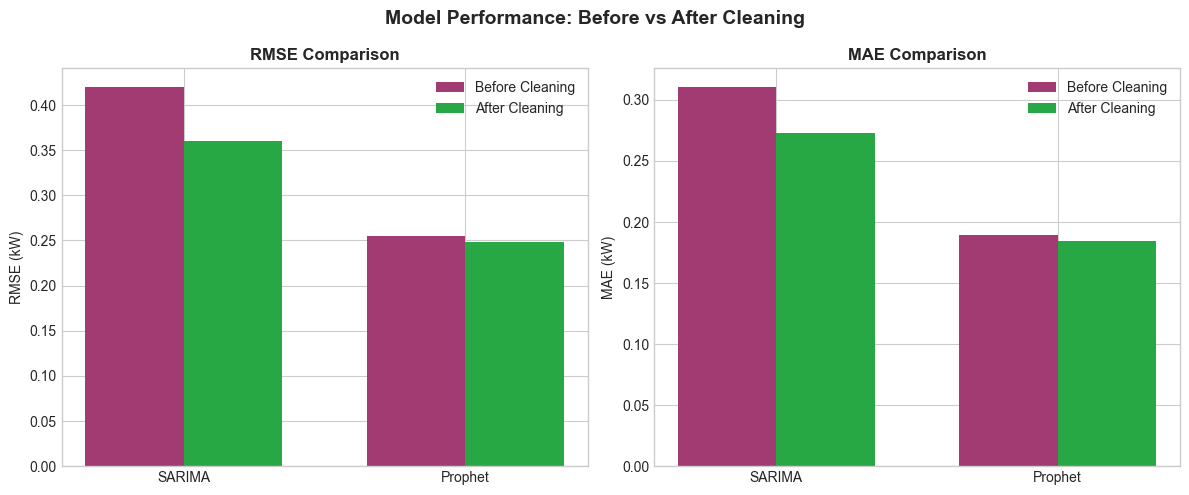

In [533]:
# Visualization: Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = ['SARIMA', 'Prophet']
x = np.arange(len(models))
width = 0.35

# RMSE comparison
rmse_before = [sarima_metrics_before['RMSE'], prophet_metrics_before['RMSE']]
rmse_after = [sarima_metrics_after['RMSE'], prophet_metrics_after['RMSE']]

axes[0].bar(x - width/2, rmse_before, width, label='Before Cleaning', color='#A23B72')
axes[0].bar(x + width/2, rmse_after, width, label='After Cleaning', color='#28A745')
axes[0].set_ylabel('RMSE (kW)')
axes[0].set_title('RMSE Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()

# MAE comparison
mae_before = [sarima_metrics_before['MAE'], prophet_metrics_before['MAE']]
mae_after = [sarima_metrics_after['MAE'], prophet_metrics_after['MAE']]

axes[1].bar(x - width/2, mae_before, width, label='Before Cleaning', color='#A23B72')
axes[1].bar(x + width/2, mae_after, width, label='After Cleaning', color='#28A745')
axes[1].set_ylabel('MAE (kW)')
axes[1].set_title('MAE Comparison', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()

plt.suptitle('Model Performance: Before vs After Cleaning', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

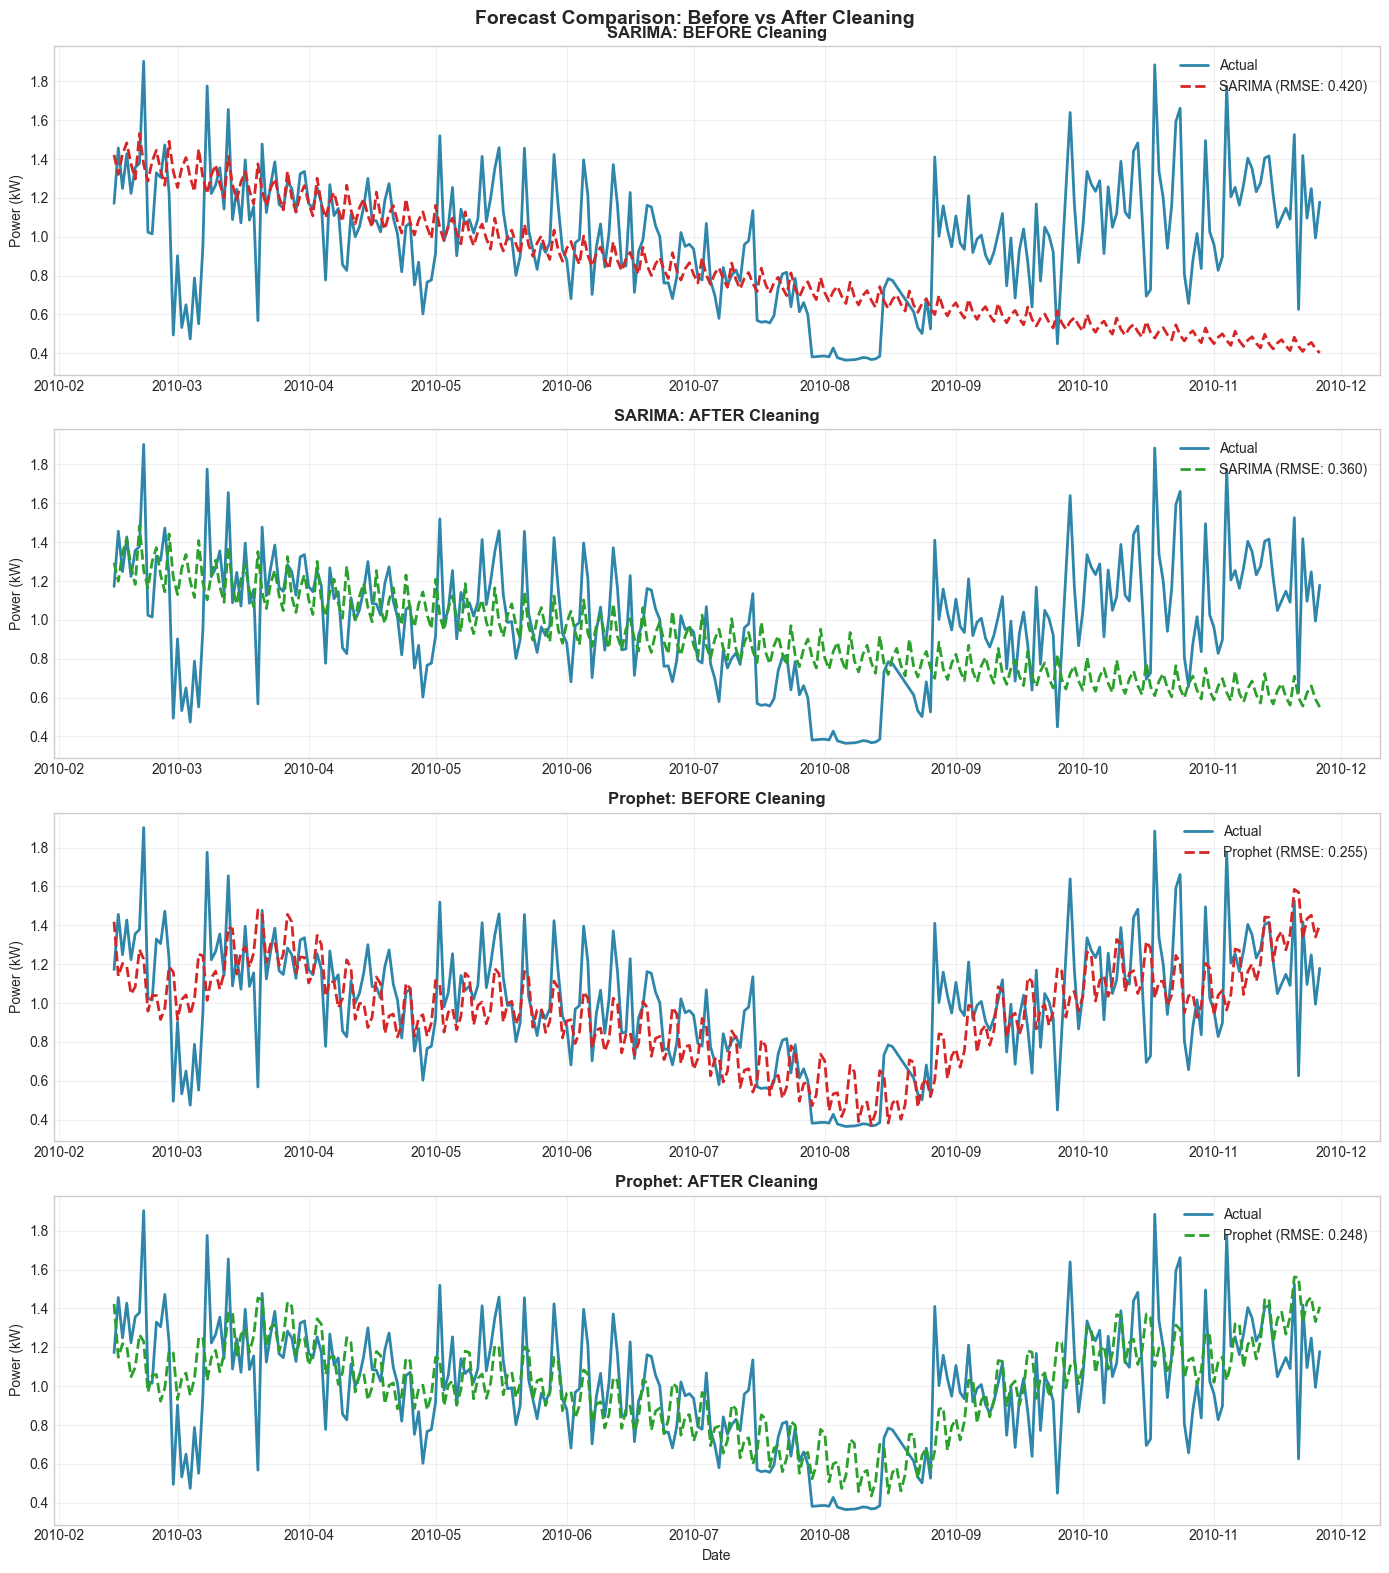


IMPROVEMENT SUMMARY

📊 SARIMA(1,0,4)(1,0,1,7):
   Before: RMSE = 0.420 kW
   After:  RMSE = 0.360 kW
   Change: +14.22%

📊 Prophet:
   Before: RMSE = 0.255 kW
   After:  RMSE = 0.248 kW
   Change: +2.49%

🏆 Best Model: Prophet (RMSE: 0.248 kW)


In [ ]:
# Forecast visualization: Before vs After 
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# SARIMA - Before Cleaning
axes[0].plot(test_original.index, test_original.values, label='Actual', color='#2E86AB', linewidth=2)
axes[0].plot(sarima_forecast_orig.index, sarima_forecast_orig.values, 
             label=f'SARIMA (RMSE: {sarima_metrics_before["RMSE"]:.3f})', 
             color='#d62728', linestyle='--', linewidth=2)
axes[0].set_title('SARIMA: BEFORE Cleaning', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Power (kW)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# SARIMA - After Cleaning
axes[1].plot(test_original.index, test_original.values, label='Actual', color='#2E86AB', linewidth=2)
axes[1].plot(sarima_forecast_clean.index, sarima_forecast_clean.values, 
             label=f'SARIMA (RMSE: {sarima_metrics_after["RMSE"]:.3f})', 
             color='#2ca02c', linestyle='--', linewidth=2)
axes[1].set_title('SARIMA: AFTER Cleaning', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Power (kW)')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# Prophet - Before Cleaning
axes[2].plot(test_original.index, test_original.values, label='Actual', color='#2E86AB', linewidth=2)
axes[2].plot(test_original.index, prophet_pred_orig, 
             label=f'Prophet (RMSE: {prophet_metrics_before["RMSE"]:.3f})', 
             color='#d62728', linestyle='--', linewidth=2)
axes[2].set_title('Prophet: BEFORE Cleaning', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Power (kW)')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

# Prophet - After Cleaning
axes[3].plot(test_original.index, test_original.values, label='Actual', color='#2E86AB', linewidth=2)
axes[3].plot(test_original.index, prophet_pred_clean, 
             label=f'Prophet (RMSE: {prophet_metrics_after["RMSE"]:.3f})', 
             color='#2ca02c', linestyle='--', linewidth=2)
axes[3].set_title('Prophet: AFTER Cleaning', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Power (kW)')
axes[3].set_xlabel('Date')
axes[3].legend(loc='upper right')
axes[3].grid(True, alpha=0.3)

plt.suptitle('Forecast Comparison: Before vs After Cleaning', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print improvement summary
print("\n" + "=" * 50)
print("IMPROVEMENT SUMMARY")
print("=" * 50)

sarima_improvement = (sarima_metrics_before['RMSE'] - sarima_metrics_after['RMSE']) / sarima_metrics_before['RMSE'] * 100
prophet_improvement = (prophet_metrics_before['RMSE'] - prophet_metrics_after['RMSE']) / prophet_metrics_before['RMSE'] * 100

print(f"\nSARIMA({p},{d},{q})({P},{D},{Q},{s}):")
print(f"   Before: RMSE = {sarima_metrics_before['RMSE']:.3f} kW")
print(f"   After:  RMSE = {sarima_metrics_after['RMSE']:.3f} kW")
print(f"   Change: {sarima_improvement:+.2f}%")

print(f"\nProphet:")
print(f"   Before: RMSE = {prophet_metrics_before['RMSE']:.3f} kW")
print(f"   After:  RMSE = {prophet_metrics_after['RMSE']:.3f} kW")
print(f"   Change: {prophet_improvement:+.2f}%")

# Determine best model
best_rmse = min(sarima_metrics_after['RMSE'], prophet_metrics_after['RMSE'])
best_model = "SARIMA" if sarima_metrics_after['RMSE'] < prophet_metrics_after['RMSE'] else "Prophet"
print(f"\nBest Model: {best_model} (RMSE: {best_rmse:.3f} kW)")

---
# FINAL SUMMARY
---

In [ ]:
print("\n" + "="*70)
print("                         PROJECT SUMMARY")
print("        Time Series Forecasting and Anomaly Detection")
print("                  Household Energy Consumption")
print("="*70)

print("\nDATASET:")
print(f"   Source: UCI Household Power Consumption")
print(f"   Period: {ts.index.min().date()} to {ts.index.max().date()}")
print(f"   Total Days: {len(ts)}")

print("\n ANOMALY DETECTION:")
print(f"   Method 1 (Z-Score):          {len(zscore_anomaly_dates)} anomalies")
print(f"   Method 2 (Isolation Forest): {len(iso_anomaly_dates)} anomalies")
print(f"   Method 3 (STL Residual):     {stl_anomalies.sum()} anomalies")
print(f"   Method 4 (Prophet Interval): {prophet_anomalies_bool.sum()} anomalies")
print(f"   Used STL Residual for cleaning (best for seasonal data)")

print("\n FORECASTING RESULTS:")
print(f"\n   SARIMA({p},{d},{q})({P},{D},{Q},{s}):")
print(f"   ├─ Before cleaning: RMSE = {sarima_metrics_before['RMSE']:.4f} kW")
print(f"   └─ After cleaning:  RMSE = {sarima_metrics_after['RMSE']:.4f} kW ({sarima_improvement:+.2f}%)")
print(f"\n   Prophet:")
print(f"   ├─ Before cleaning: RMSE = {prophet_metrics_before['RMSE']:.4f} kW")
print(f"   └─ After cleaning:  RMSE = {prophet_metrics_after['RMSE']:.4f} kW ({prophet_improvement:+.2f}%)")

# Best model
best_rmse = min(sarima_metrics_after['RMSE'], prophet_metrics_after['RMSE'])
best_model = 'SARIMA' if sarima_metrics_after['RMSE'] < prophet_metrics_after['RMSE'] else 'Prophet'
print(f"\nBEST MODEL: {best_model} (RMSE: {best_rmse:.4f} kW)")

print("\nKEY INSIGHTS:")
print("   1. Energy data has clear weekly and yearly seasonality")
print("   2. STL Residual anomaly detection works best for seasonal data")
print("   3. Data cleaning improved forecast accuracy")
print("   4. Prophet captures seasonal patterns effectively")
print("   5. SARIMA requires careful parameter tuning for optimal results")

print("\n" + "="*70)


                         PROJECT SUMMARY
        Time Series Forecasting and Anomaly Detection
                  Household Energy Consumption

📊 DATASET:
   Source: UCI Household Power Consumption
   Period: 2007-01-01 to 2010-11-26
   Total Days: 1426

🔍 ANOMALY DETECTION:
   Method 1 (Z-Score):          11 anomalies
   Method 2 (Isolation Forest): 29 anomalies
   Method 3 (STL Residual):     40 anomalies
   Method 4 (Prophet Interval): 87 anomalies
   ➡️  Used STL Residual for cleaning (best for seasonal data)

📉 FORECASTING RESULTS:

   SARIMA(1,0,4)(1,0,1,7):
   ├─ Before cleaning: RMSE = 0.4197 kW
   └─ After cleaning:  RMSE = 0.3600 kW (+14.22%)

   Prophet:
   ├─ Before cleaning: RMSE = 0.2548 kW
   └─ After cleaning:  RMSE = 0.2485 kW (+2.49%)

🏆 BEST MODEL: Prophet (RMSE: 0.2485 kW)

💡 KEY INSIGHTS:
   1. Energy data has clear weekly and yearly seasonality
   2. STL Residual anomaly detection works best for seasonal data
   3. Data cleaning improved forecast accuracy
   4. Pr